# 1. Imports

In [1]:
import json
import random
import pickle
import requests
import inflection
import numpy      as np
import pandas     as pd
import xgboost    as xgb
import seaborn    as sns
import sweetviz   as sv
import scikitplot as skplt

from flask            import Flask, request, Response
from tabulate         import tabulate
from scipy            import stats           as ss
from sklearn          import ensemble        as en
from sklearn          import neighbors       as nh
from sklearn          import preprocessing   as pp
from sklearn          import model_selection as ms
from sklearn          import linear_model    as lm
from sklearn          import metrics         as mt
from matplotlib       import pyplot          as plt
from imblearn.combine import SMOTETomek

import warnings
warnings.filterwarnings( 'ignore' )

c:\Users\Felipe\Documents\Felipe\CienciaDeDados\repos\purchasing_propensity\insurance\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Helper functions

In [2]:
def description_cols():
    description = [
    ['Variable', 'Definition'],
    ['id', 'Customer Iedntifier'],
    ['Gender', 'Customer Gender'],
    ['Age', 'Customer Age'],
    ['Driving_License', '0 : Customer does not have DL, 1 : Customer already has DL'],
    ['Region_Code', 'Customer Region Code'],
    ['Previously_Insured', '1 : Customer already has Vehicle Insurance, 0 : Customer doesn\'t have Vehicle Insurance'],
    ['Vehicle_Age', 'Vehicle Age'],
    ['Vehicle_Damage', '1 : Customer has already had damage to their car. 0 : Customer has never had damaged to their car'],
    ['Annual_Premium', 'Amount paid to the company for health insurance, annualy'],
    ['Policy_Sales_Channel', 'Anonymous code for customer contact'],
    ['Vintage', 'Number of days the customer purchased health insurance'],
    ['Response', '1 : Interested Customer, 0 : Not interested customer']
    ]

    print(tabulate(description, headers='firstrow', tablefmt='fancy_grid', showindex=True))

def rename_columns(data):
    new_columns = {col: inflection.underscore(col) for col in data.columns}
    return data.rename(columns=new_columns)

def feature_engineering(data):
        # vehicle age
    data['vehicle_age'] = data['vehicle_age'].apply( lambda x: 'over_2_years' if x == '> 2 Years' 
                                                else 'between_1_2_year' if x == '1-2 Year' 
                                                else 'below_1_year' ) 

    # vehicle damage
    data['vehicle_damage'] = data['vehicle_damage'].apply(lambda x: 1 if x == 'Yes' else 0)

    return data

def description_insights():
    description = [
    ['Variable', 'Insights'],
    ['Gender', '''- There are more men (54%) than women (46%) in the customer base
- Of all customers, 12% are likely to buy insurance
- 14% of all men and 10% of women would buy insurance
- There is clustering of groups'''],
    ['Age', '- Despite the large concentration of customers up to 30 years old, a large part of the probability of purchasing vehicle insurance is among customers aged 35-50'],
    ['Drive License', '''- There is group segmentation. Important variable, but must be combined with age.
- There are many people with a driving license who do not want car insurance. Investigate the reason'''],
    ['Region Code', '''- There is a region with a lot of concentration and high purchasing propensity.
- Did not create cluster groups.
- Alone, this variable is not interesting. Perhaps combined with another variable it would be useful.'''],
    ['Previously Insured', '''- People who already have vehicle insurance do not want to exchange their insurance for the company's.
- There is a data leak: the previously_insurance variable is almost telling the model the answer.
- The correlation with the response variable is very high, as if those who already have vehicle insurance would not buy the company's insurance.
- Almost an if/else (if you have insurance -> don't buy it)'''],
    ['Vehicle Age', '''- There are many new cars, up to 2 years old.
- As cars get older, their owners are more likely to purchase vehicle insurance'''],
    ['Vehice Damage', '- People with a damaged vehicle are more likely to buy than those without damage.'],
    ['Annual Premium', '''- This variable alone is not relevant. Maybe combined with another.
- Similar shapes and medians. Cannot target groups.'''],
    ['Policy Sales Channel', '- Channels 26 and 124 bring more customers likely to buy'],
    ['Vintage', '''- There is no group segmentation. The data is homogeneous. 
- The distribution is uniform.
- This variable alone is not relevant. Maybe combined with another.'''],
    ['Response', '- Unbalanced response variable with 88% not interested and only 12% interested'],
    
    ]

    print(tabulate(description, headers='firstrow', tablefmt='fancy_grid', showindex=True))

def cramer_v(x, y):
    cm = pd.crosstab( x, y ).values
    n = cm.sum()
    r, k = cm.shape

    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1) * (r-1) / (n-1) )
    kcorr = k - (k-1)**2 / (n-1) 
    rcorr = r - (r-1)**2 / (n-1) 

    return float(np.sqrt( (chi2corr/n) / ( min( kcorr - 1, rcorr - 1 ) ) ))

def standardization_data( data ):
    # annual_premium
    ss = pp.StandardScaler()
    data['annual_premium'] = ss.fit_transform(data[['annual_premium']].values)
    pickle.dump(ss, open('../api/features/annual_premium_scaler.pkl', 'wb'))

    return data

def rescaling_data( data ):
    # age (por causa do gráfico)
    mms_age = pp.MinMaxScaler()
    data['age'] = mms_age.fit_transform(data[['age']].values)
    pickle.dump(mms_age, open('../api/features/age_scaler.pkl', 'wb'))

    # vintage (por causa do gráfico)
    mms_vintage = pp.MinMaxScaler()
    data['vintage'] = mms_vintage.fit_transform(data[['vintage']].values)
    pickle.dump(mms_vintage, open('../api/features/vintage_scaler.pkl', 'wb'))

    return data

def encoding_data( data ):
    # gender - Target Encoding** / One Hot Encoding 
    target_encode_gender = data.groupby('gender')['response'].mean()
    data.loc[:,'gender'] = data['gender'].map(target_encode_gender)
    pickle.dump(target_encode_gender, open('../api/features/target_encode_gender_scaler.pkl', 'wb'))

    # region_code -  One Hot Encoding (until 6 different types) / Frequency Encoding / Target Encoding** / Weighted Encoding
    target_encode_region_code = data.groupby('region_code')['response'].mean()
    data.loc[:,'region_code'] = data['region_code'].map(target_encode_region_code)
    pickle.dump(target_encode_region_code, open('../api/features/target_encode_region_code_scaler.pkl', 'wb'))

    # vehicle_age (categorical variable)  One Hot Encoding** / Order Encoding / Frequency Encoding
    data = pd.get_dummies(data, prefix='vehicle_age', columns=['vehicle_age'])

    # policy_sales_channel - Target Encoding / Frequency Encoding**
    fe_policy_sales_channel = data.groupby('policy_sales_channel').size() / len(data)
    data.loc[:,'policy_sales_channel'] = data['policy_sales_channel'].map(fe_policy_sales_channel)
    pickle.dump(fe_policy_sales_channel, open('../api/features/fe_policy_sales_channel_scaler.pkl', 'wb'))
    
    return data

def precision_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k(data, k=2000):
    # reset index
    data = data.reset_index(drop=True)
    # create ranking order
    data['ranking'] = data.index + 1
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

def metrics_models(data, model_name, y_val, yhat, x_val):
    
    data = x_val.copy()
    data['response'] = y_val.copy()
    # Score
    data['score'] = yhat[:,1].tolist()
    # Sorting customers by propensity score
    data = data.sort_values('score', ascending=False)

    # Calculate Precision at K
    precision = precision_at_k(data, k=2000)
    # Calculate Recall at k
    recall =  recall_at_k(data, k=2000)

    return pd.DataFrame({'Model Name': model_name,
                         'Precision at K': precision,
                         'Recall at K': recall}, index=[0])

def cross_validation(model, x_train, y_train, k, data, Verbose=True):
    kfold = ms.StratifiedKFold(n_splits=k, shuffle=True, random_state=28)
    precision_list = []
    precision_k_list = []
    recall_k_list = []
    balanced_list = []
    i=1

    for train_cv, val_cv in kfold.split(x_train, y_train):
        if Verbose == True:
            print(f'Fold number: {i}/{k}')
        
        else:
            pass

        x_train_fold = x_train.iloc[train_cv]
        y_train_fold = y_train.iloc[train_cv]
        x_val_fold = x_train.iloc[val_cv]
        y_val_fold = y_train.iloc[val_cv]

        model_fit = model.fit(x_train_fold, y_train_fold.values.ravel())
        yhat = model.predict_proba(x_val_fold)
        yhat_1 = model.predict(x_val_fold)

        data = x_val_fold.copy()
        data['response'] = y_val_fold.copy()
        data['score'] = yhat[:,1].tolist()
        data = data.sort_values('score', ascending=False)

        precision_k = precision_at_k(data, k=4000)
        precision_k_list.append(precision_k)

        recall_k = recall_at_k(data, k=4000)
        recall_k_list.append(recall_k)

        precision = mt.precision_score(y_val_fold, yhat_1)
        precision_list.append(precision)

        balanced_accuracy = mt.balanced_accuracy_score(y_val_fold, yhat_1)
        balanced_list.append(balanced_accuracy)

        i+=1

    df = pd.DataFrame({'Model Name': type(model).__name__,
                       'Balanced Accuracy Mean': np.mean(balanced_list).round(4),
                       'Precision Mean': np.mean(precision_list).round(4),
                       'Precision STD': np.std(precision_list).round(4),
                       'Precision@k Mean': np.mean(precision_k_list).round(4),
                       'Precision@k STD': np.std(precision_k_list).round(4),
                       'Recall@k Mean': np.mean(recall_k_list).round(4),
                       'Recall@k STD': np.std(recall_k_list).round(4)},
                       index=[0])

    return df

# 3. Loading Data

In [3]:
df_raw = pd.read_csv('../data/train.csv', low_memory=False)
df_raw.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


# 4. Data Description

## 4.0 Description

In [4]:
description_cols()

╒════╤══════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Variable             │ Definition                                                                                        │
╞════╪══════════════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ id                   │ Customer Iedntifier                                                                               │
├────┼──────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│  1 │ Gender               │ Customer Gender                                                                                   │
├────┼──────────────────────┼───────────────────────────────────────────────────────────────────────────────────────────────────┤
│  2 │ Age                  │ Customer Age                                                

In [5]:
df1 = df_raw.copy()
df1 = rename_columns(df1)
df1.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## 4.1 Data Dimension

In [6]:
df1.shape

(381109, 12)

## 4.2 Data Types

In [7]:
df1.dtypes

id                        int64
gender                   object
age                       int64
driving_license           int64
region_code             float64
previously_insured        int64
vehicle_age              object
vehicle_damage           object
annual_premium          float64
policy_sales_channel    float64
vintage                   int64
response                  int64
dtype: object

## 4.3 Check NA

In [8]:
df1.isna().sum()

id                      0
gender                  0
age                     0
driving_license         0
region_code             0
previously_insured      0
vehicle_age             0
vehicle_damage          0
annual_premium          0
policy_sales_channel    0
vintage                 0
response                0
dtype: int64

## 4.4 Data Descriptive

In [9]:
num_attributes = df1.select_dtypes(include=(['int64', 'float64']))
cat_attributes = df1.select_dtypes(exclude=(['int64', 'float64', 'datetime64[ns]']))

In [10]:
# Central Tendency - Mean, Median
mean_ = pd.DataFrame(num_attributes.apply(np.mean)).T
median_ = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis
std_ = pd.DataFrame(num_attributes.apply(np.std)).T
min_ = pd.DataFrame(num_attributes.apply(min)).T
max_ = pd.DataFrame(num_attributes.apply(max)).T
range_ = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skew_ = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis_ = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std',
             'skew', 'kurtosis']

m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190555.000000,190555.0,110016.691870,9.443274e-16,-1.200000
1,age,20.0,85.0,65.0,38.822584,36.0,15.511591,6.725390e-01,-0.565655
2,driving_license,0.0,1.0,1.0,0.997869,1.0,0.046109,-2.159518e+01,464.354302
3,region_code,0.0,52.0,52.0,26.388807,28.0,13.229871,-1.152664e-01,-0.867857
4,previously_insured,0.0,1.0,1.0,0.458210,0.0,0.498251,1.677471e-01,-1.971871
5,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.132474,1.766087e+00,34.004569
6,policy_sales_channel,1.0,163.0,162.0,112.034295,133.0,54.203924,-9.000081e-01,-0.970810
7,vintage,10.0,299.0,289.0,154.347397,154.0,83.671194,3.029517e-03,-1.200688
8,response,0.0,1.0,1.0,0.122563,0.0,0.327935,2.301906e+00,3.298788


# 5. Feature Engineering

In [11]:
df2 = df1.copy()

In [12]:
df2 = feature_engineering(df2)

# 6. Data Filtering

In [13]:
df3 = df2.copy()
# After analyzing the data, no conditions necessary to apply a filter were verified. There's no apparently outlier data thet needs to be removed.

# 7. EDA

In [14]:
df4 = df3.copy()

# For classification projects, we need to clustering two classes or two groups. One group interested in vehicle insurance and another not.
# In this case, we're interested in ranking all customers based on their probability of purchasing a vehicle insurance.

## 7.1 Univariate Analysis

### 7.1.1 Response

<Axes: xlabel='response', ylabel='Count'>

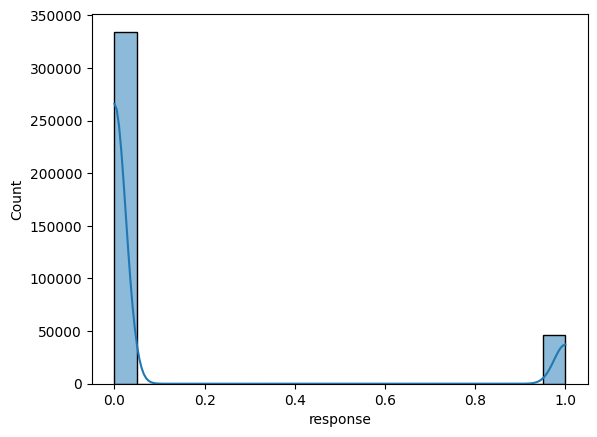

In [15]:
sns.histplot(df4['response'], kde=True)

### 7.1.2 Numericals

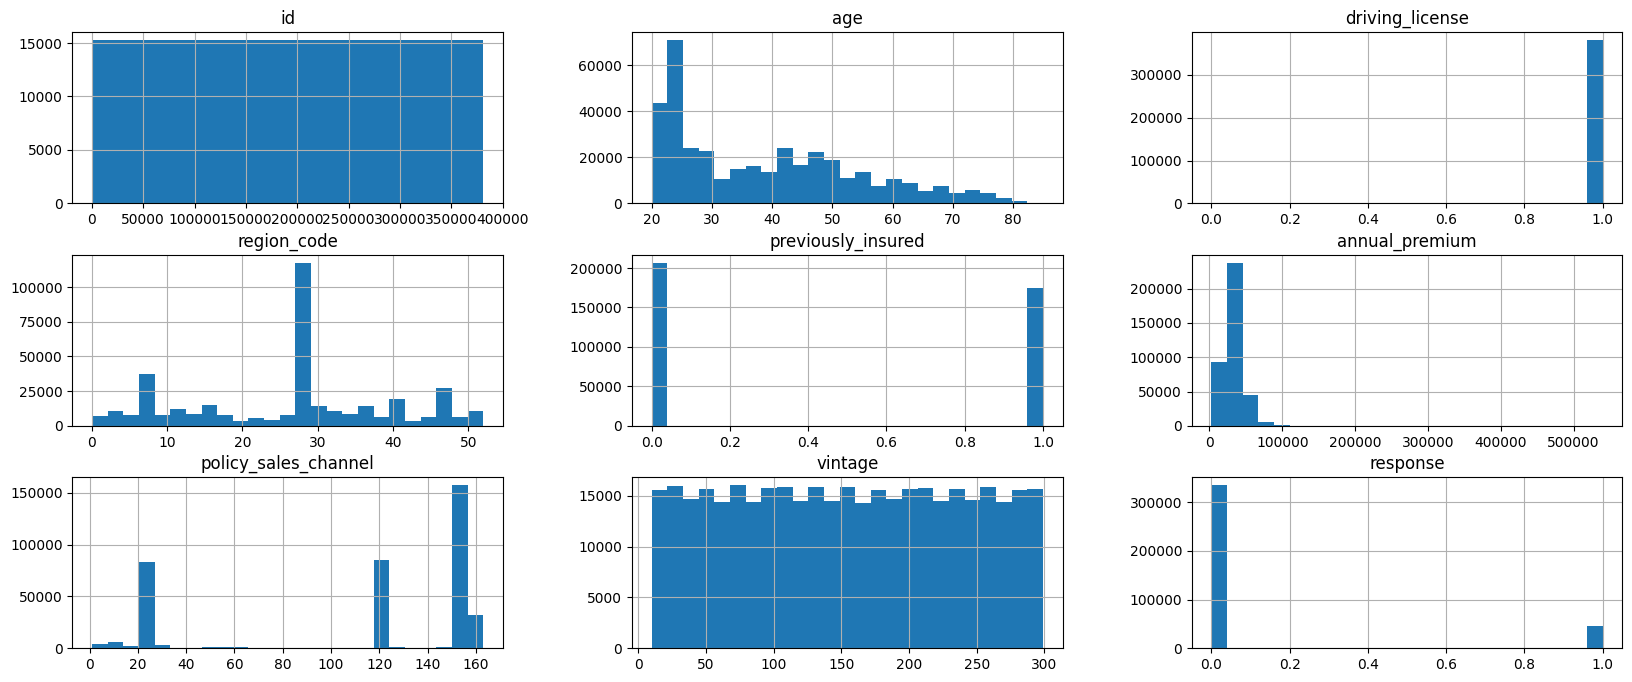

In [16]:
num_attributes.hist(bins=25, figsize=(20,8));

### 7.1.3 Categorical

In [17]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

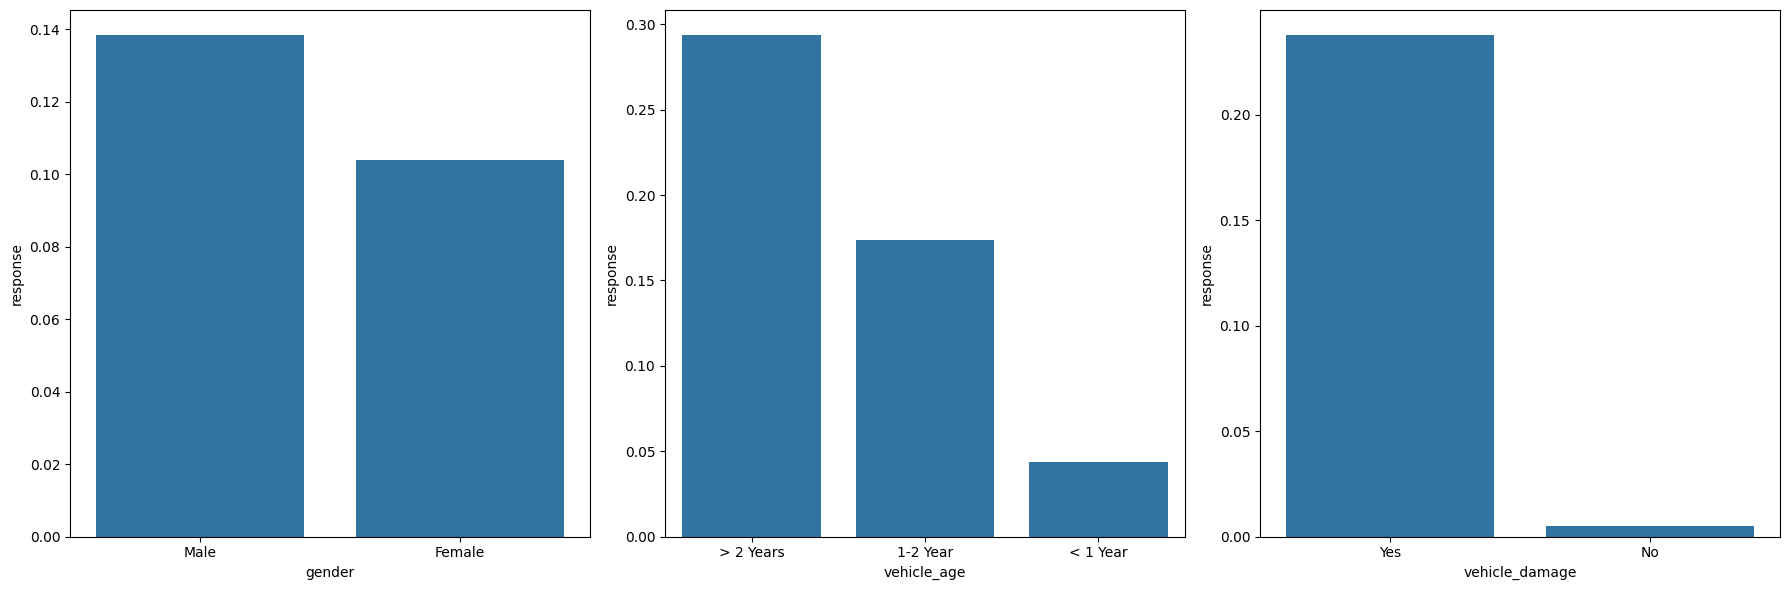

In [18]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.barplot(x='gender', y='response', data=df1, errorbar=None)

plt.subplot(1,3,2)
sns.barplot(x='vehicle_age', y='response', data=df1, errorbar=None)

plt.subplot(1,3,3)
sns.barplot(x='vehicle_damage', y='response', data=df1, errorbar=None)

plt.tight_layout()
plt.show()

## 7.2 Bivariate Analysis

### 7.2.1 Age

- There is a lot of data (25,000) on 'not interested' concentrated on age 20-25.
- There is little data (1,750) in 'interested'. The highest concentration is in people aged 40-50.
- This variable is promising for separating the set into two classes, but it is unbalanced.

<Axes: xlabel='response', ylabel='age'>

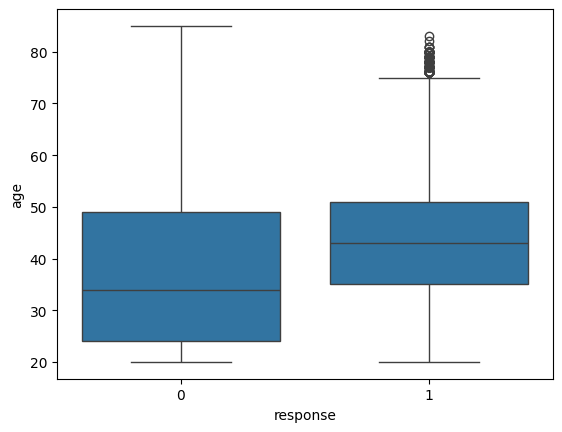

In [19]:
sns.boxplot(x='response', y='age', data=df4)

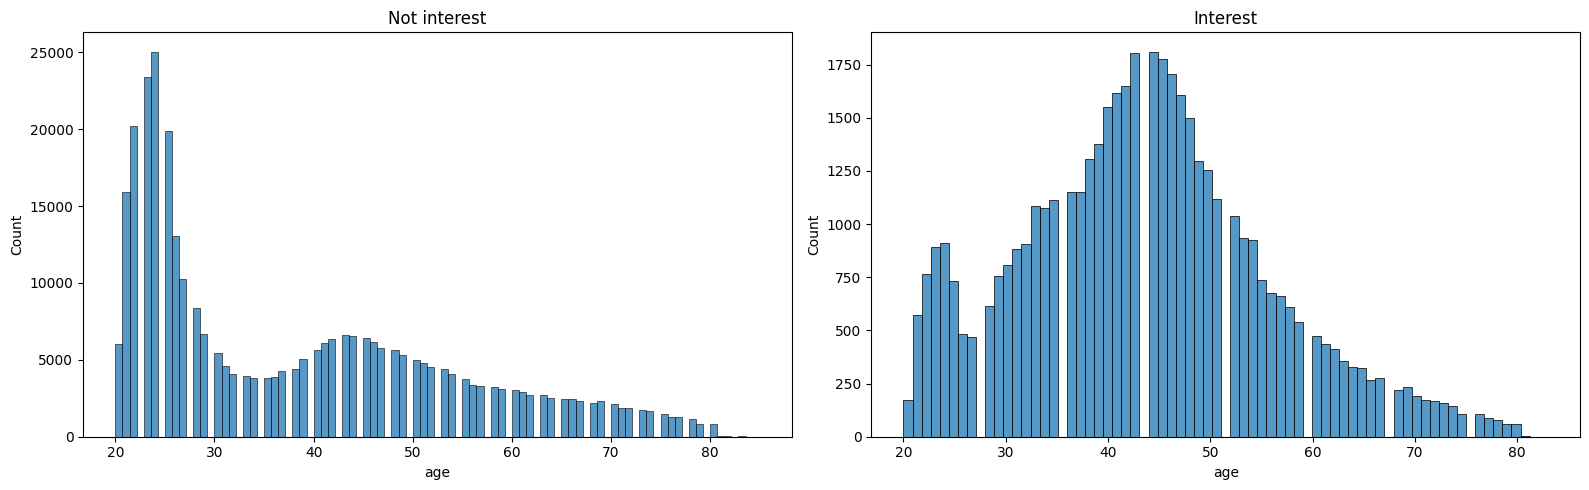

In [20]:
plt.figure(figsize=(16,5))

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.2.2 Annual Premium

- This variable alone is not relevant. Maybe combined with another.
- Similar shapes and medians. Cannot target groups.

<Axes: xlabel='response', ylabel='annual_premium'>

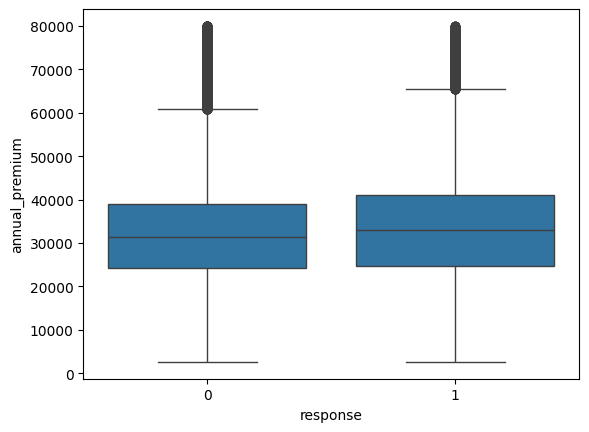

In [21]:
aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x='response', y='annual_premium', data=aux)

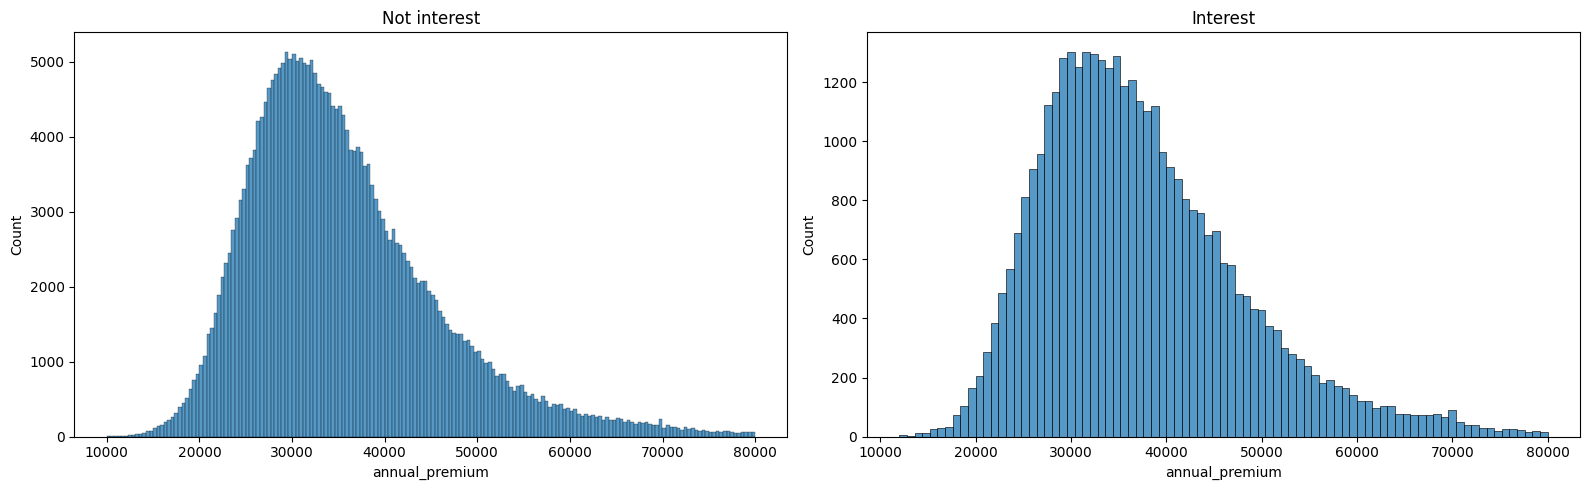

In [22]:
plt.figure(figsize=(16,5))
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]

plt.subplot(1, 2, 1)
plt.title('Not interest')
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(aux0)

plt.subplot(1, 2, 2)
plt.title('Interest')
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.2.3 Driving License

- There is group segmentation. Important variable, but must be combined with age.
- There are many people with a driving license who do not want car insurance. Investigate the reason.

In [23]:
aux = df4[['driving_license', 'response']].groupby('response').sum().reset_index()
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
aux.head()

,response,driving_license,driving_license_perc
0,0,333628,0.877283
1,1,46669,0.122717


<Axes: xlabel='response', ylabel='driving_license'>

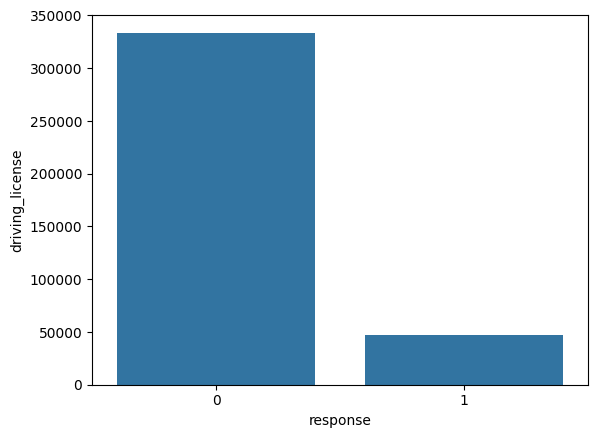

In [24]:
sns.barplot(x='response', y='driving_license', data=aux)

### 7.2.4 Region Code

- Did not create cluster groups.
- Alone, this variable is not interesting. Perhaps combined with another variable it would be useful.
- Different regions have different interest in insurance

<Axes: xlabel='region_code', ylabel='id'>

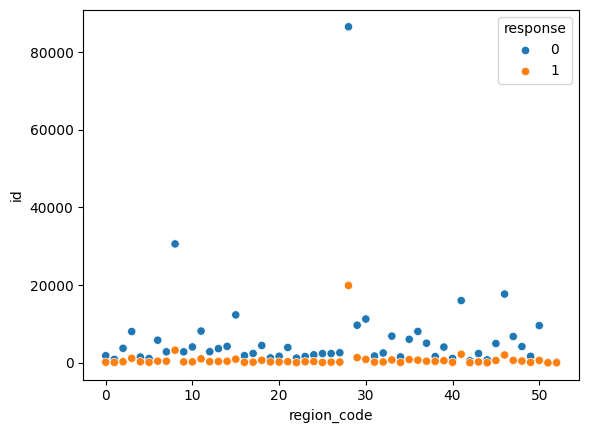

In [25]:
aux0 = df4[['id', 'region_code', 'response']].groupby(['region_code', 'response']).count().reset_index()
sns.scatterplot(data=aux0, x='region_code', y='id', hue='response')

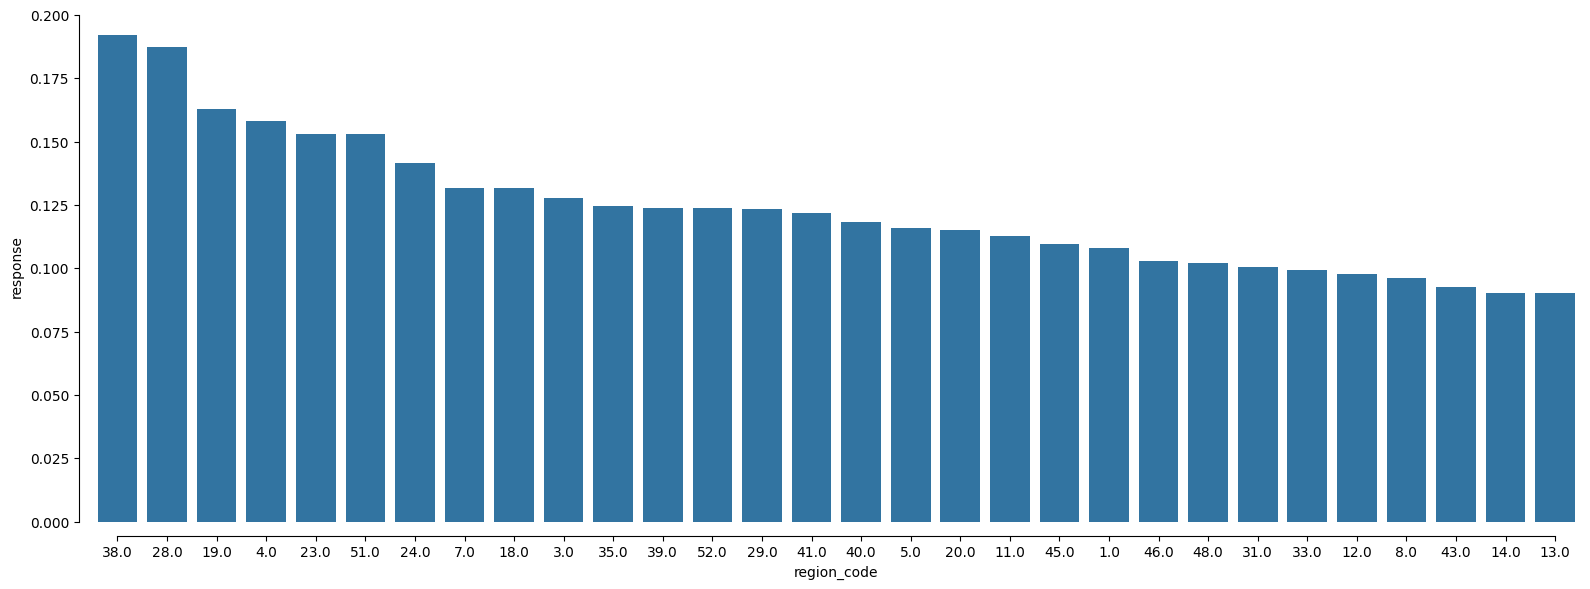

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
region_code,38.000000,28.000000,19.000000,4.000000,23.000000,51.000000,24.000000,7.000000,18.000000,3.000000,35.000000,39.0000,52.000000,29.000000,41.000000
response,0.192004,0.187163,0.162866,0.158245,0.153061,0.153005,0.141615,0.131747,0.131574,0.127662,0.124604,0.1236,0.123596,0.123362,0.121776


In [26]:
plt.figure(figsize=(16,6))
aux_region = df4[['region_code', 'response']].groupby('region_code').mean().sort_values(by='response', ascending=False).reset_index()
sns.barplot(x='region_code', y='response', data=aux_region, order = aux_region['region_code'].head(30))
sns.despine(offset=10, trim=True)

plt.tight_layout()
plt.show()
aux_region.head(15).T

### 7.2.5 Previously Insured

- People who already have vehicle insurance do not want to exchange their insurance for the company's.
- There is a data leak: the previously_insurance variable is almost telling the model the answer.
- The correlation with the response variable is very high, as if those who already have vehicle insurance would not buy the company's insurance.
- Almost an if/else (if you have insurance -> don't buy it)

In [27]:
pd.crosstab(df4['previously_insured'], df4['response']).apply(lambda x: round((x/x.sum())*100, 2), axis=1)

response,0,1
previously_insured,,
0,77.45,22.55
1,99.91,0.09


- 0 0 = People who DO NOT have health insurance and DO NOT want car insurance
- 0 1 = People who DO NOT have health insurance and want car insurance
- 1 0 = People who have health insurance and do NOT want car insurance
- 1 1 = People who have health insurance and want car insurance

### 7.2.6 Vehicle Age

- For new cars up to 1 year old and those 1-2 years old, there is group discrimination.
- For older cars, the groups are similar.

In [28]:
df4[['vehicle_age', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_age')
# sns.scatterplot(data=aux0, x='vehicle_age', y='id', hue='response')

,vehicle_age,response,proportion
1,below_1_year,0,0.413488
4,below_1_year,1,0.018897
0,between_1_2_year,0,0.434285
2,between_1_2_year,1,0.091328
3,over_2_years,0,0.029663
5,over_2_years,1,0.012338


### 7.2.7 Vehicle Damage

- People with a damaged vehicle are more likely to buy than those without damage.

In [29]:
df4[['vehicle_damage', 'response']].value_counts(normalize=True).reset_index().sort_values('vehicle_damage')

,vehicle_damage,response,proportion
0,0,0,0.492547
3,0,1,0.002577
1,1,0,0.384890
2,1,1,0.119987


### 7.2.8 Gender

- There is clustering of groups.

In [30]:
df4[['gender', 'response']].value_counts(normalize=True).reset_index().sort_values('gender')

,gender,response,proportion
1,Female,0,0.411523
3,Female,1,0.047716
0,Male,0,0.465914
2,Male,1,0.074847


### 7.2.9 Policy Sales Channel

- Did not create cluster groups.
- Alone, this variable is not interesting. Perhaps combined with another variable it would be useful.

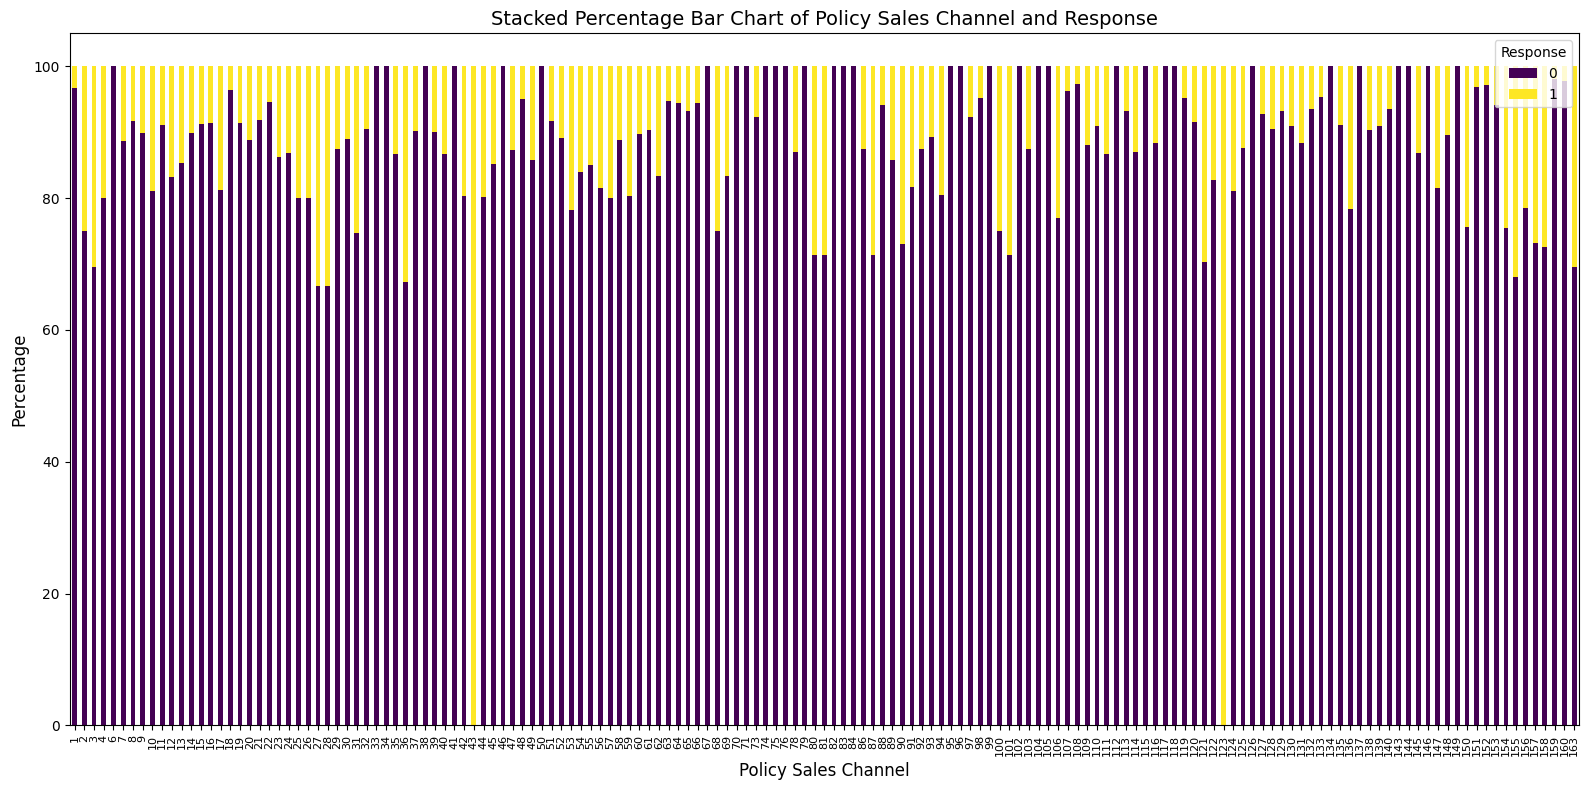

In [31]:
# Prepare the data for the stacked bar chart
stacked_data = (df4.groupby(['policy_sales_channel', 'response']).size()
                .unstack(fill_value=0))

# Convert counts to percentages
stacked_data_percentage = stacked_data.div(stacked_data.sum(axis=1),
                                           axis=0) * 100

# Plot
stacked_data_percentage.plot(kind='bar', stacked=True, figsize=(16, 8),
                             colormap='viridis')

# Add labels and title
plt.title('Stacked Percentage Bar Chart of Policy Sales Channel and Response',
          fontsize=14)
plt.xlabel('Policy Sales Channel', fontsize=12)
plt.ylabel('Percentage', fontsize=12)
plt.legend(title='Response', loc='upper right', fontsize=10)
plt.xticks(range(len(stacked_data_percentage.index)), 
           labels=stacked_data_percentage.index.astype(int), 
           rotation=90, fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


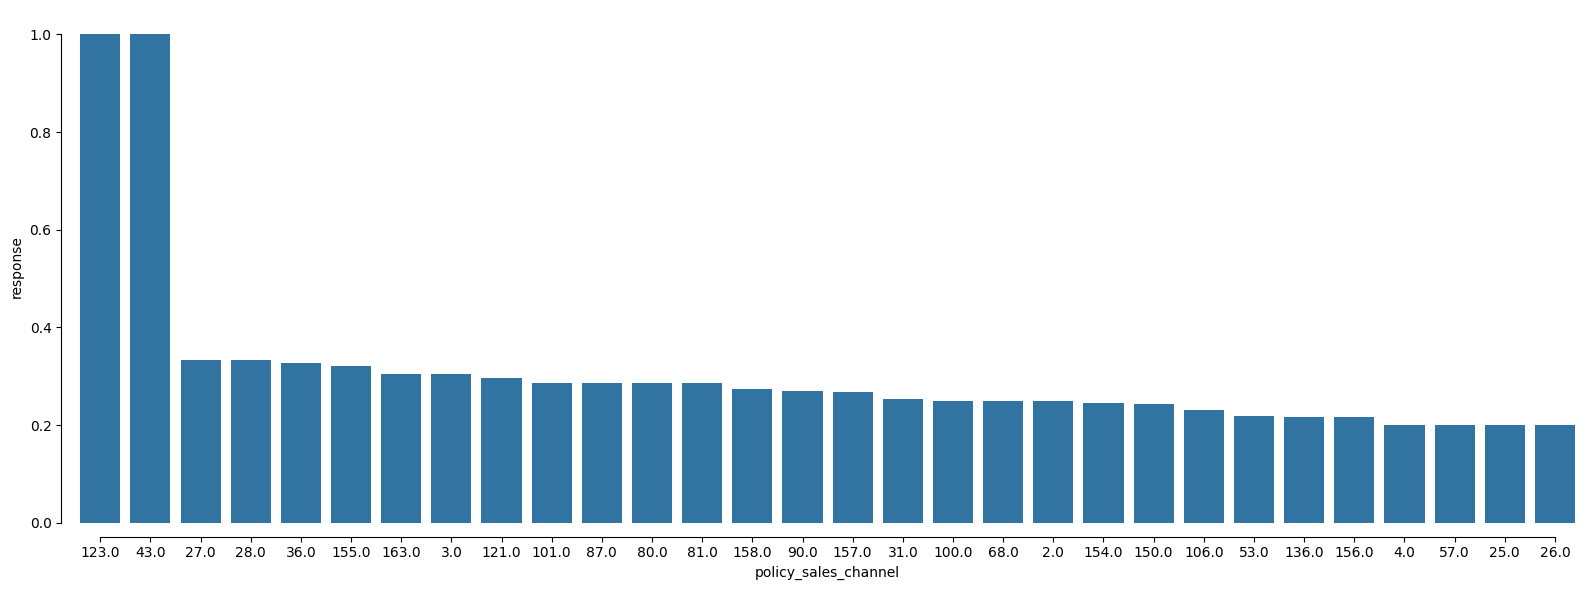

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
policy_sales_channel,123.0,43.0,27.000000,28.000000,36.000000,155.000000,163.000000,3.000000,121.000000,101.000000,87.000000,80.000000,81.000000,158.00000,90.000000
response,1.0,1.0,0.333333,0.333333,0.326923,0.320097,0.304183,0.304015,0.296875,0.285714,0.285714,0.285714,0.285714,0.27439,0.269231


In [32]:
plt.figure(figsize=(16,6))
aux_policy = df4[['policy_sales_channel', 'response']].groupby('policy_sales_channel').mean().sort_values(by='response', ascending=False).reset_index()
sns.barplot(x='policy_sales_channel', y='response', data=aux_policy, order = aux_policy['policy_sales_channel'].head(30))
sns.despine(offset=10, trim=True)

plt.tight_layout()
plt.show()
aux_policy.head(15).T

### 7.2.10 Vintage

- There is no group segmentation. The data is homogeneous. 
- The distribution is uniform.
- This variable alone is not relevant. Maybe combined with another.

<Axes: xlabel='response', ylabel='vintage'>

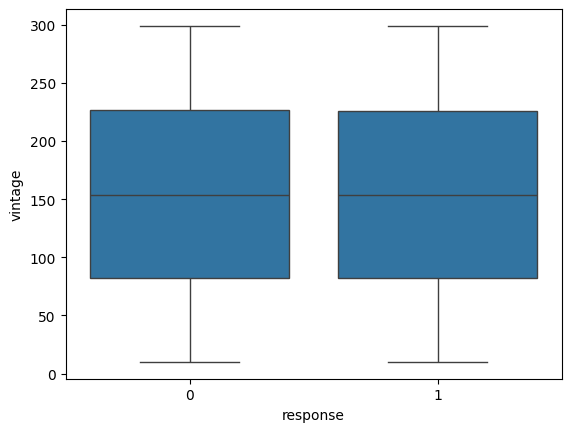

In [33]:
sns.boxplot(x='response', y='vintage', data=df4)

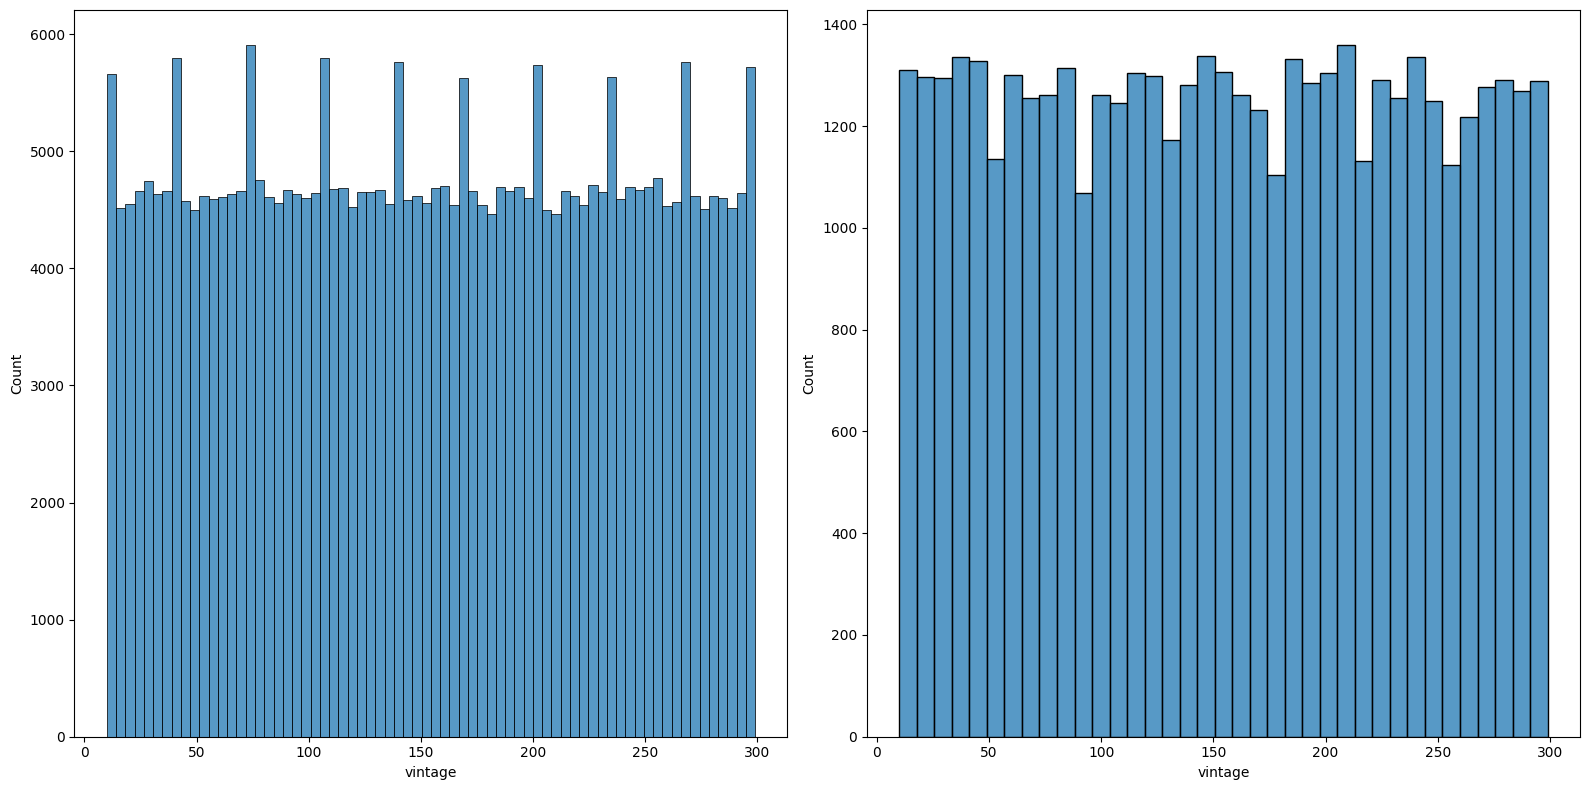

In [34]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
aux = df4.loc[df4['response'] == 0, 'vintage']
sns.histplot(aux) 

plt.subplot(1, 2, 2)
aux1 = df4.loc[df4['response'] == 1, 'vintage']
sns.histplot(aux1)

plt.tight_layout()
plt.show()

### 7.2.11 SweetViz

In [35]:
report = sv.analyze(df4, target_feat='response')
report.show_html(filepath='sweetviz_reports.html', open_browser=False)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report sweetviz_reports.html was generated.



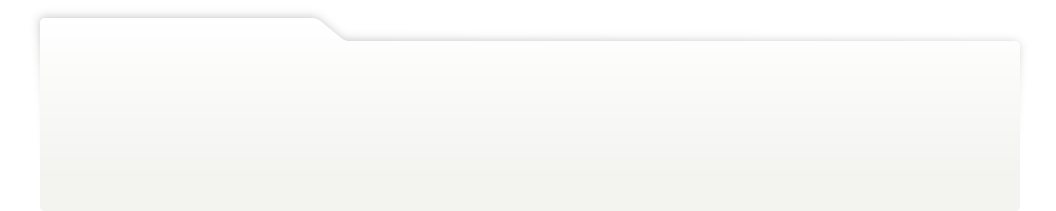
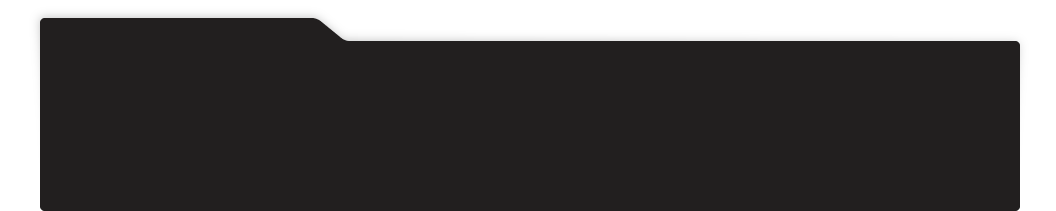
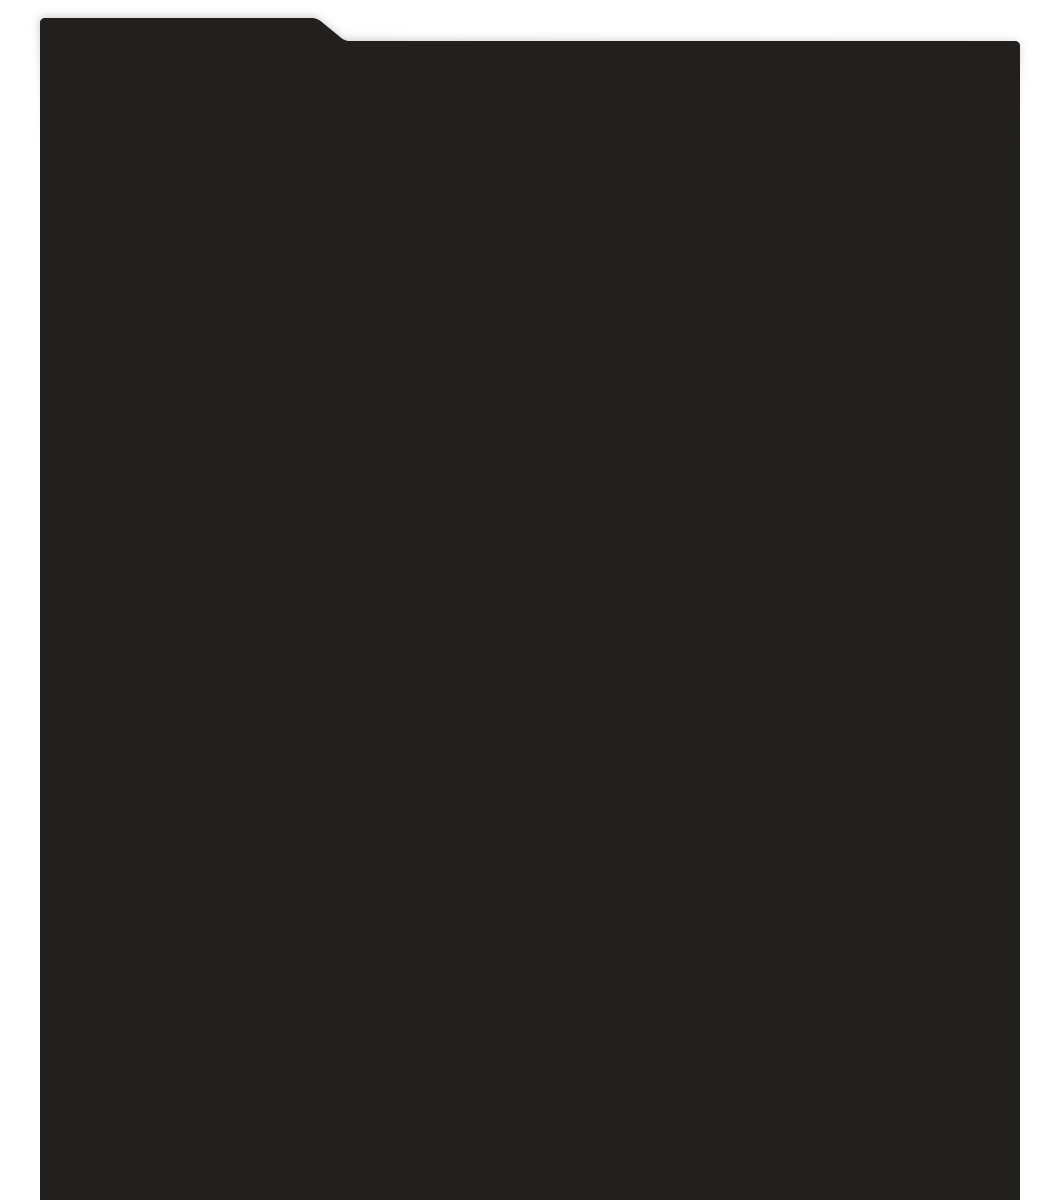
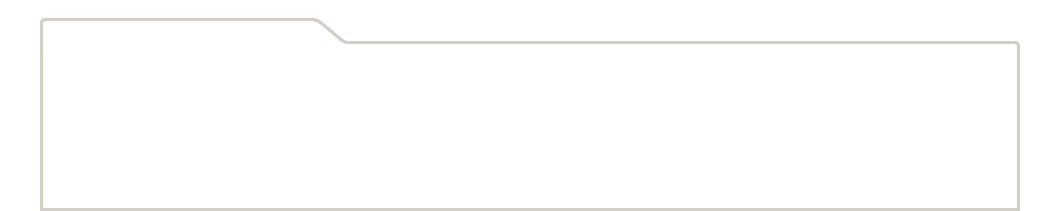
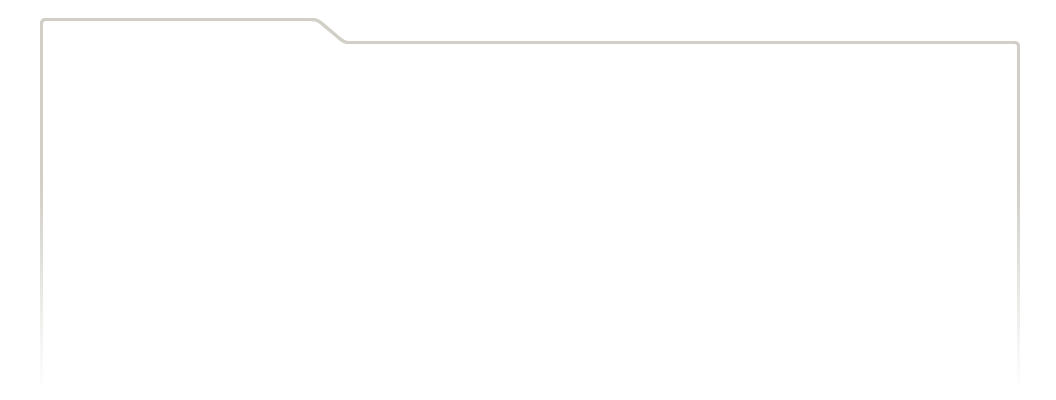
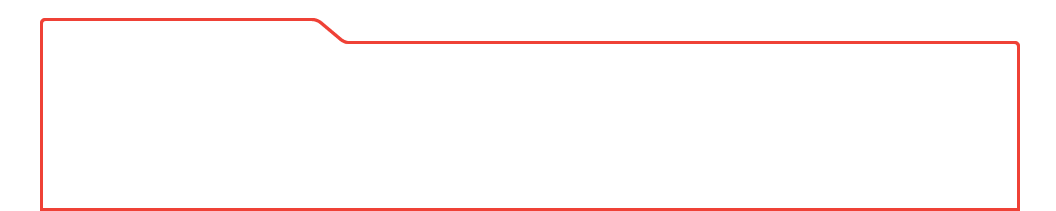
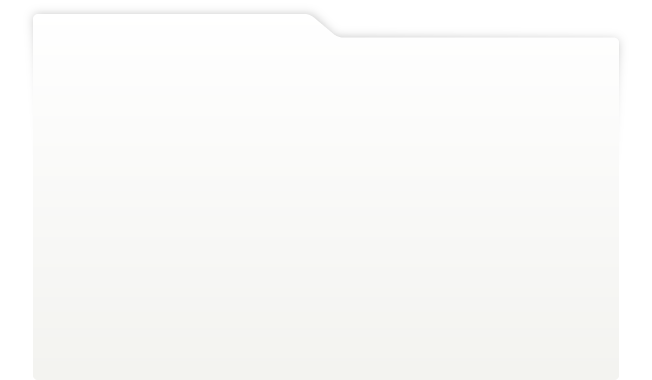
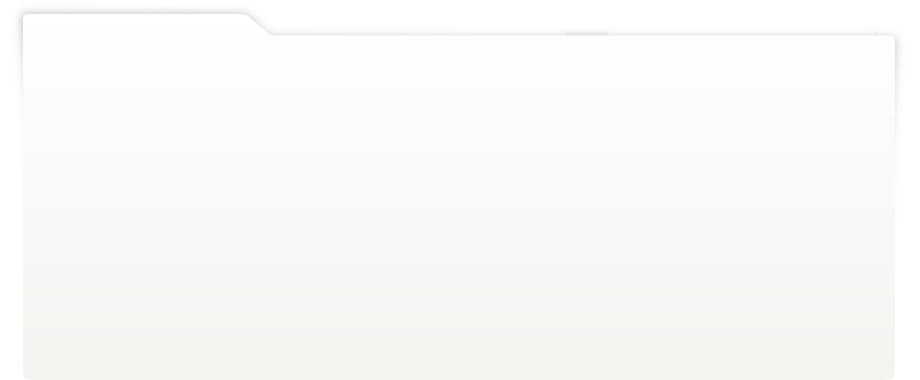
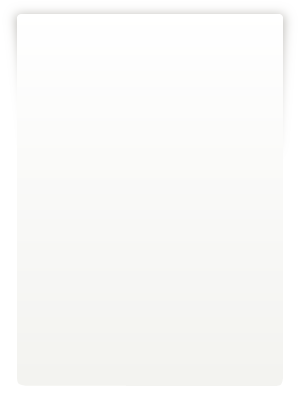
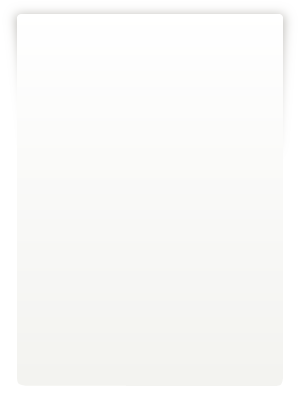
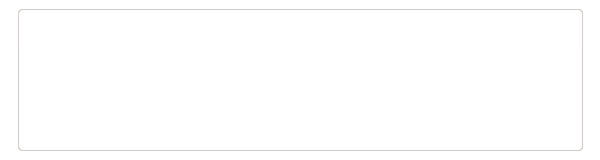
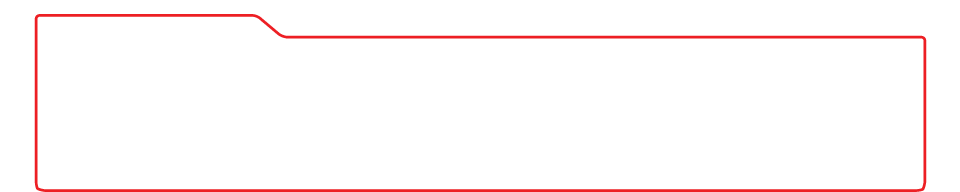
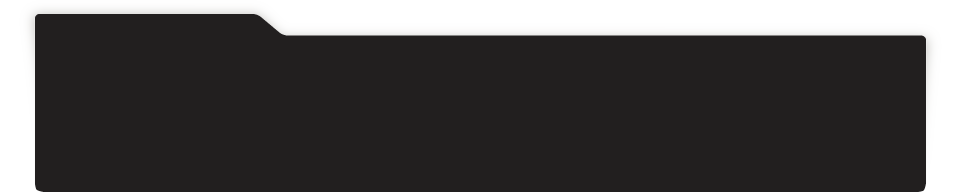
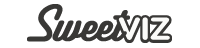
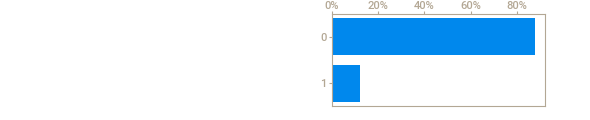
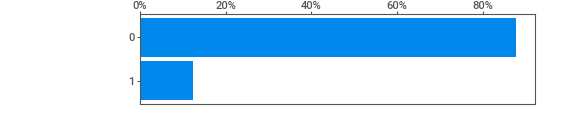
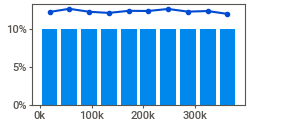
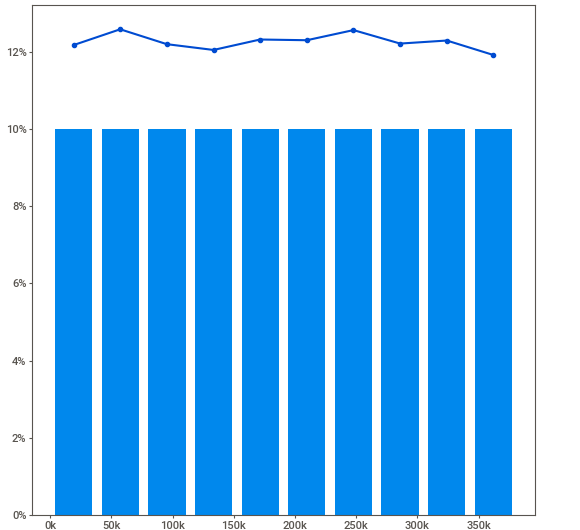
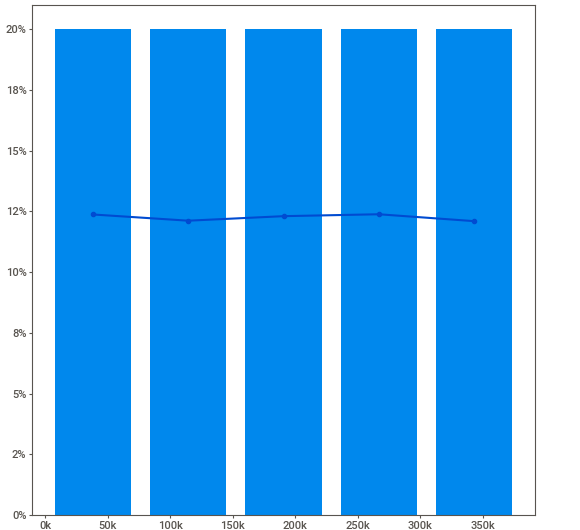
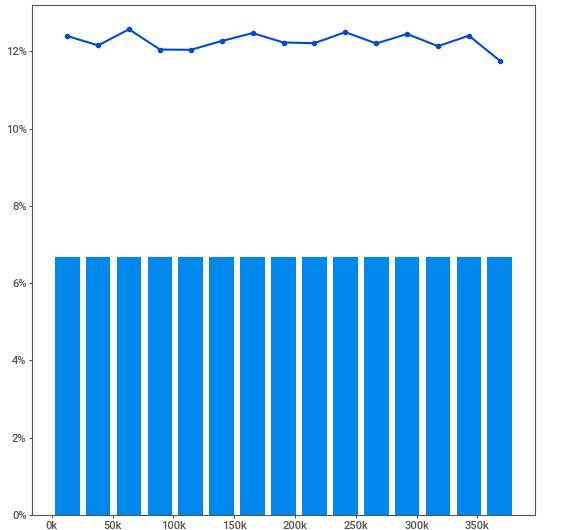
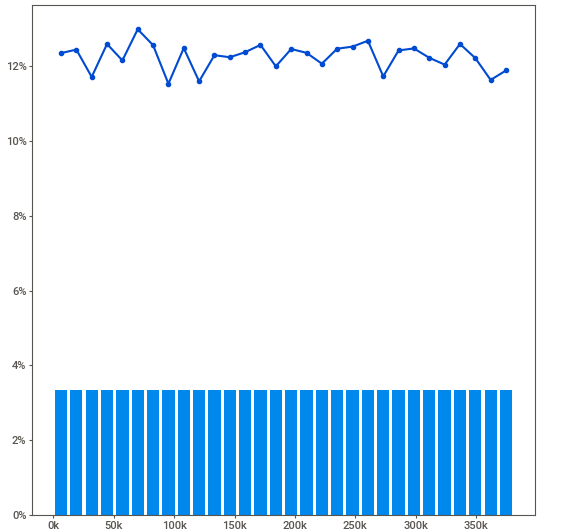
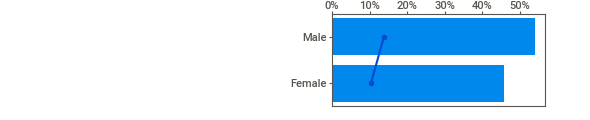
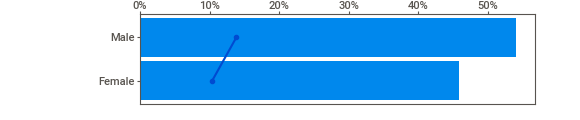
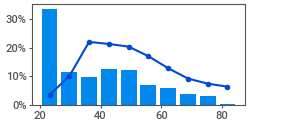
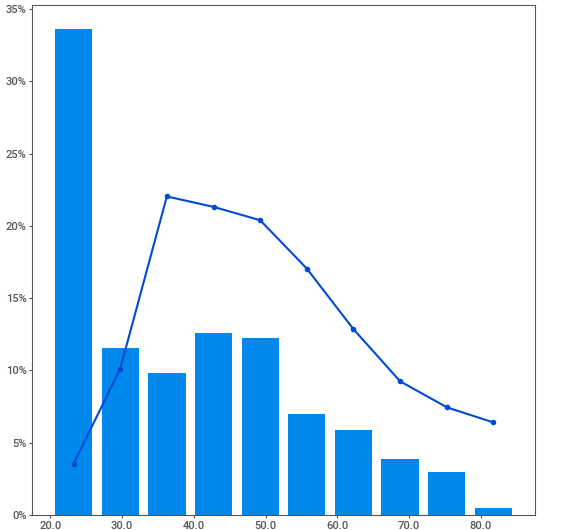
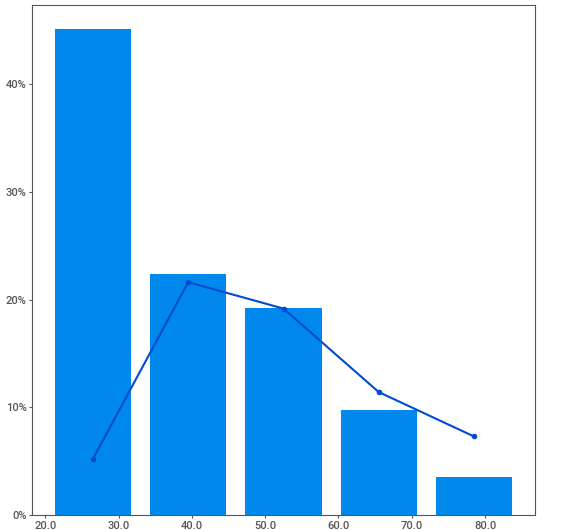
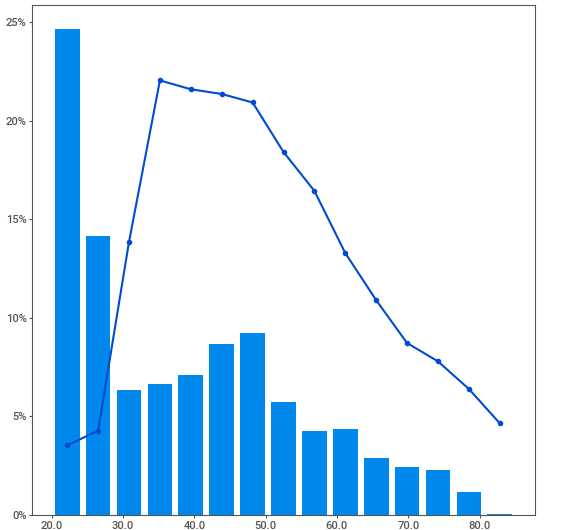
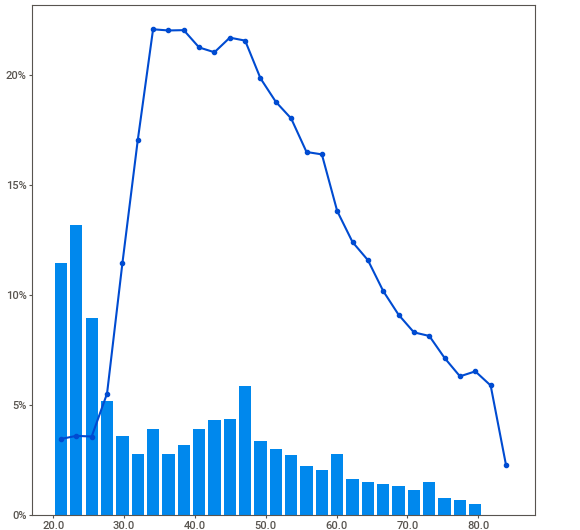
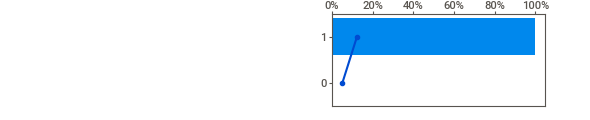
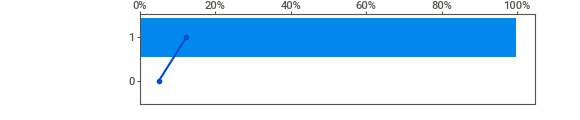
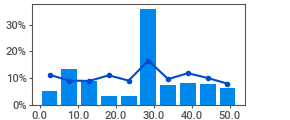
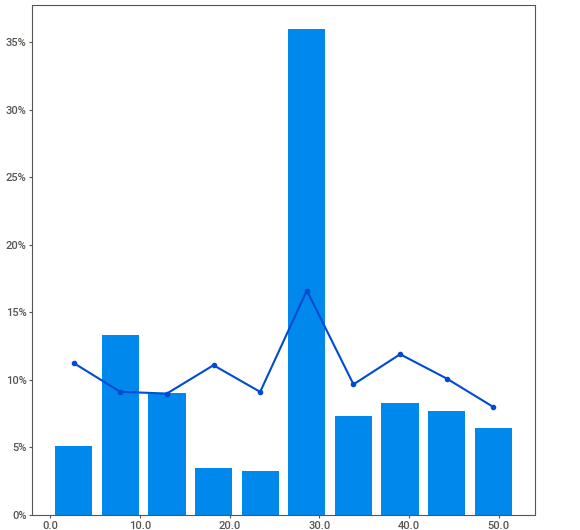
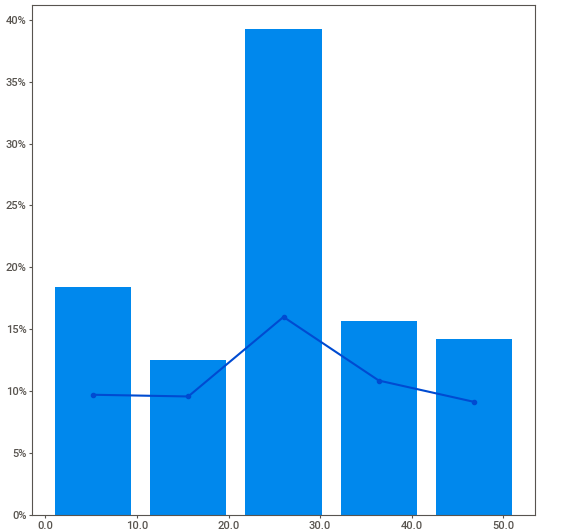
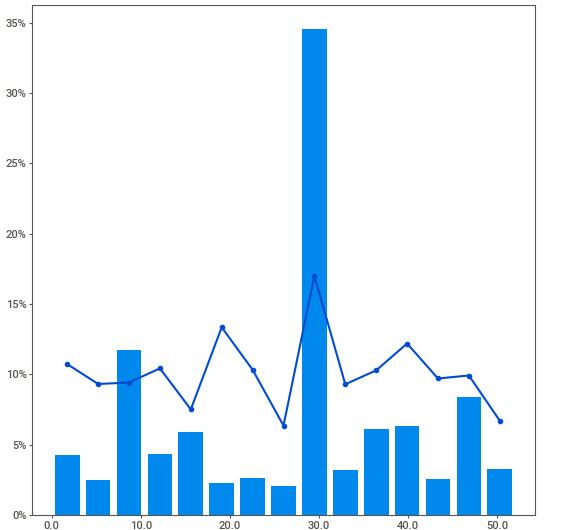
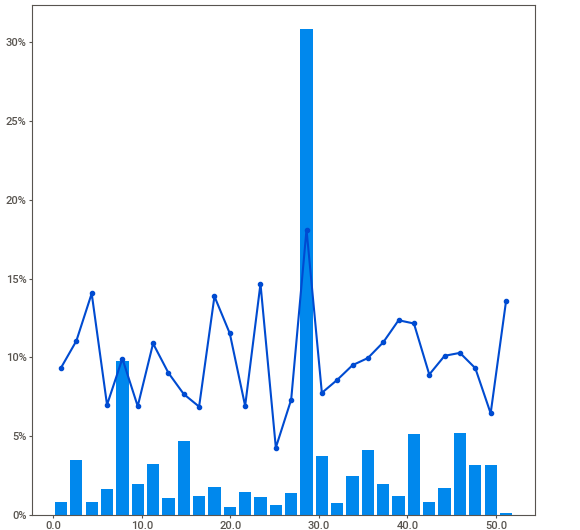
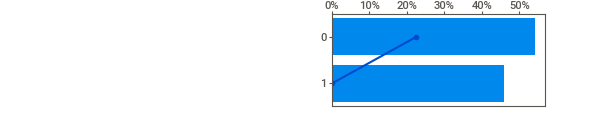
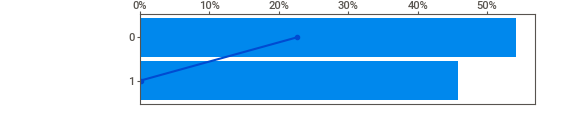
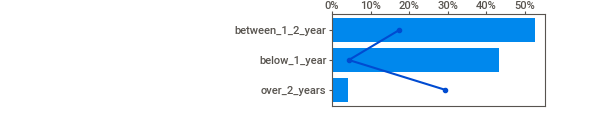
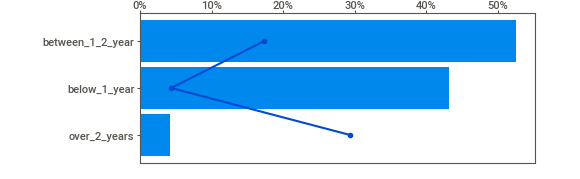
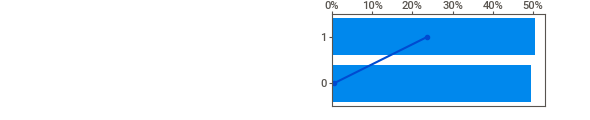
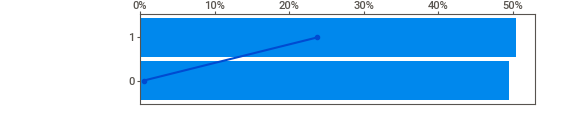
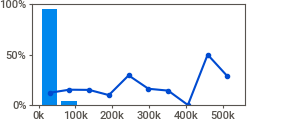
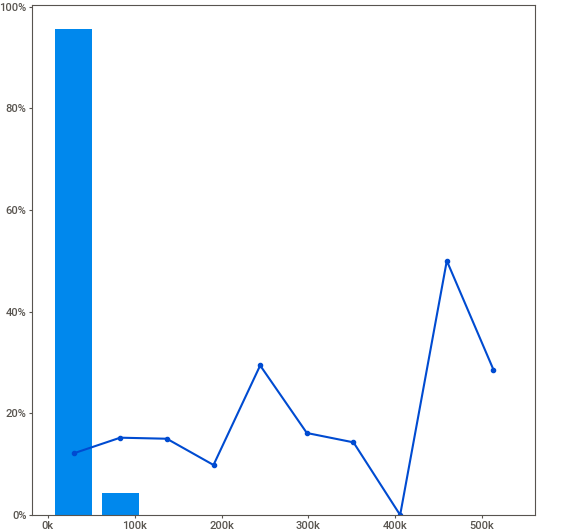
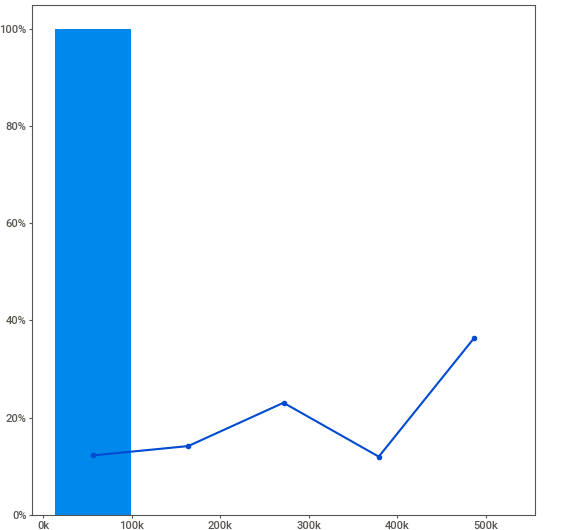
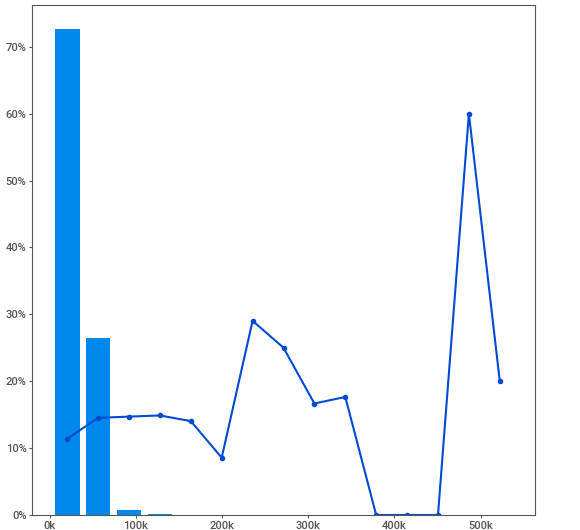
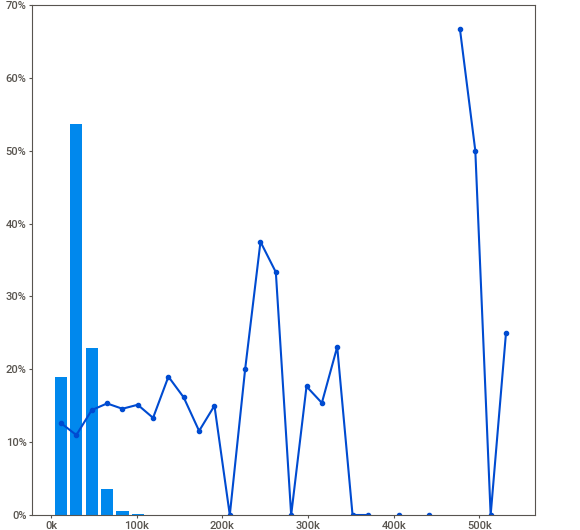
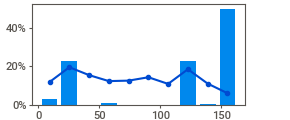
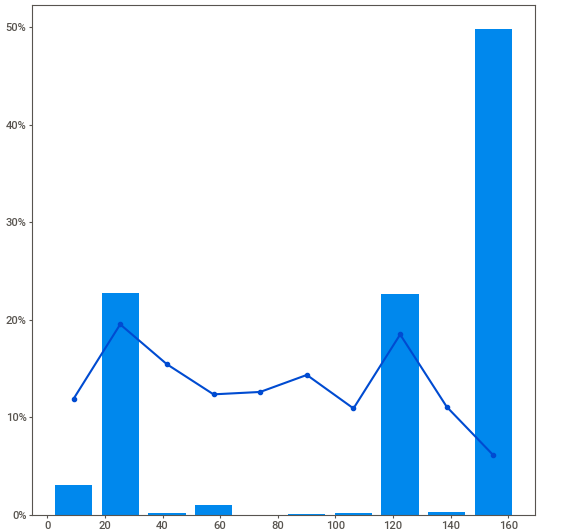
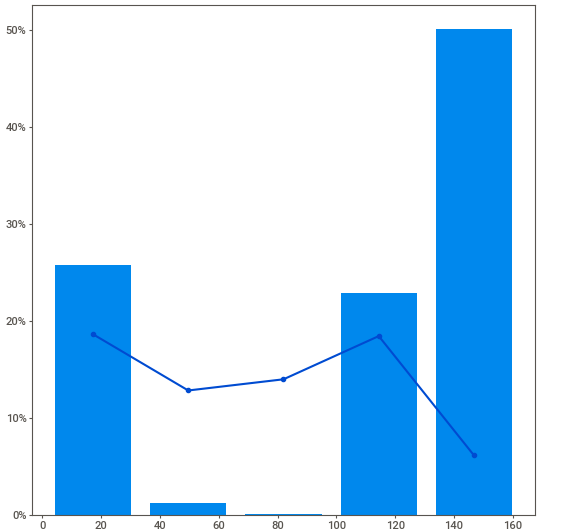
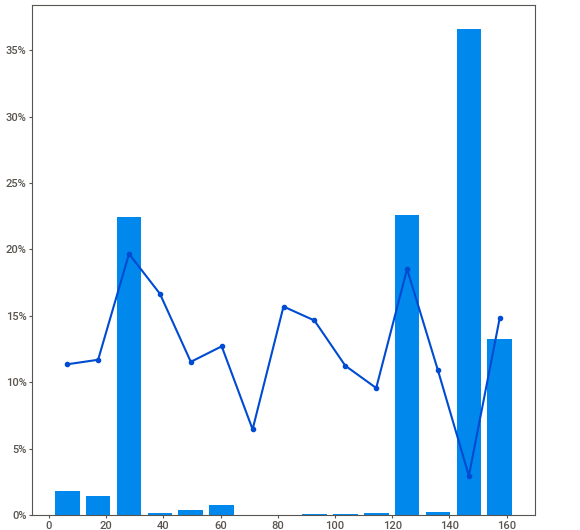
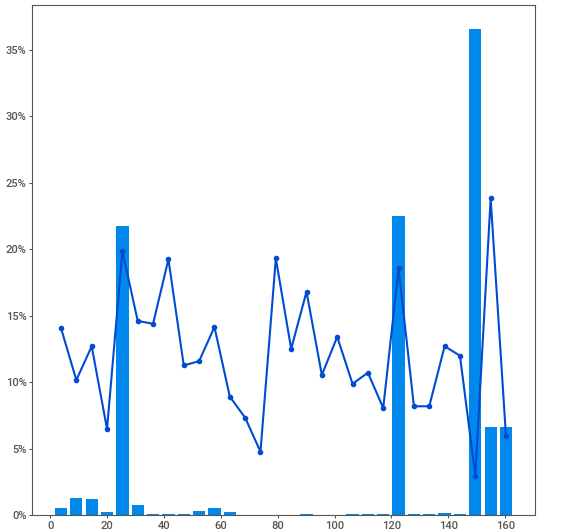
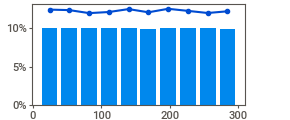
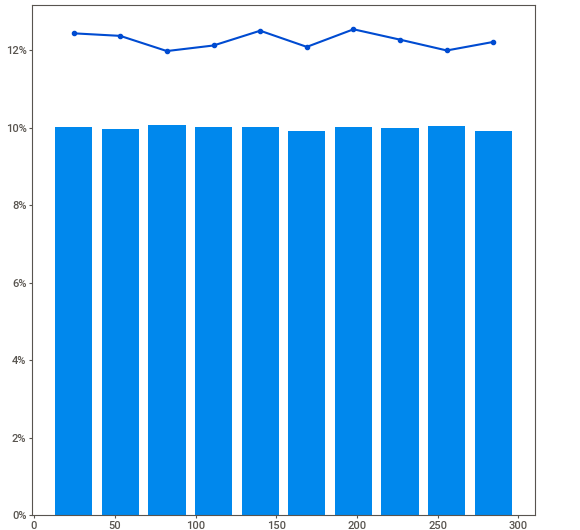
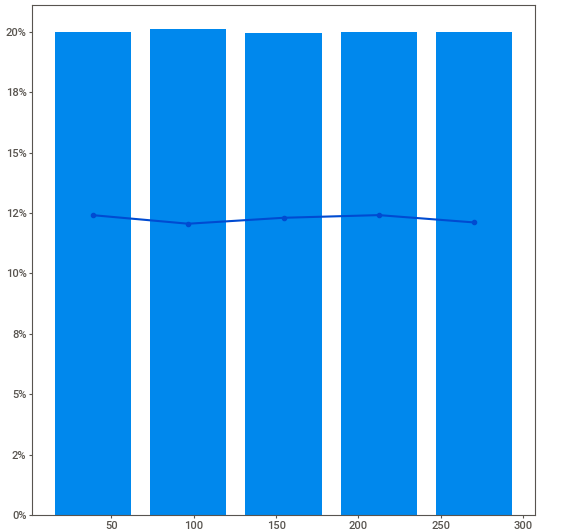
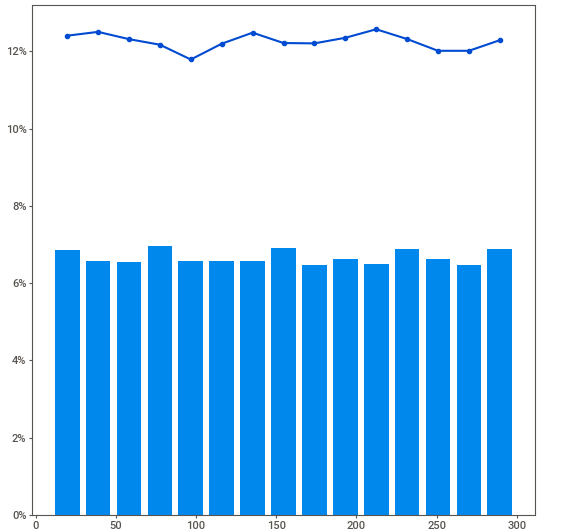
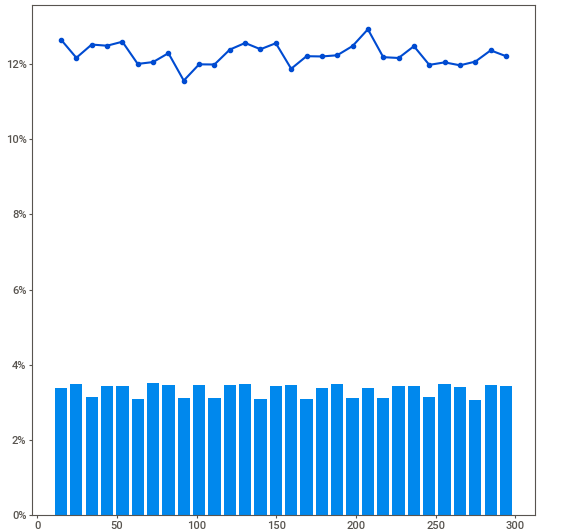
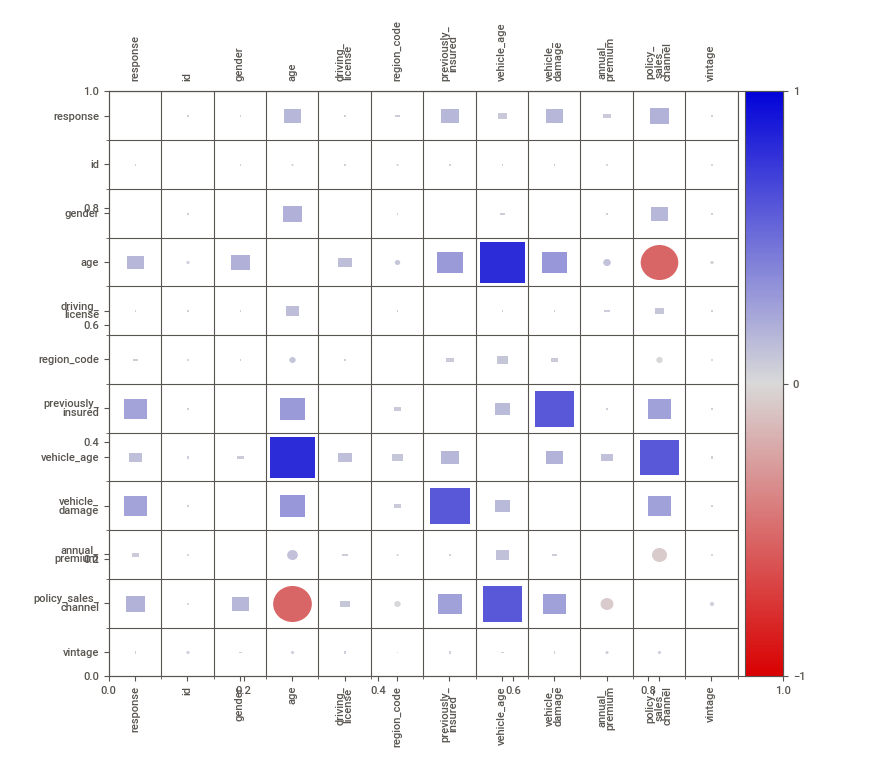
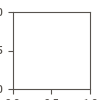

In [36]:
report.show_notebook(w=None, h=None, scale=None, layout='vertical')

## 7.3 Multivariate Analysis

### 7.3.1 Numerical

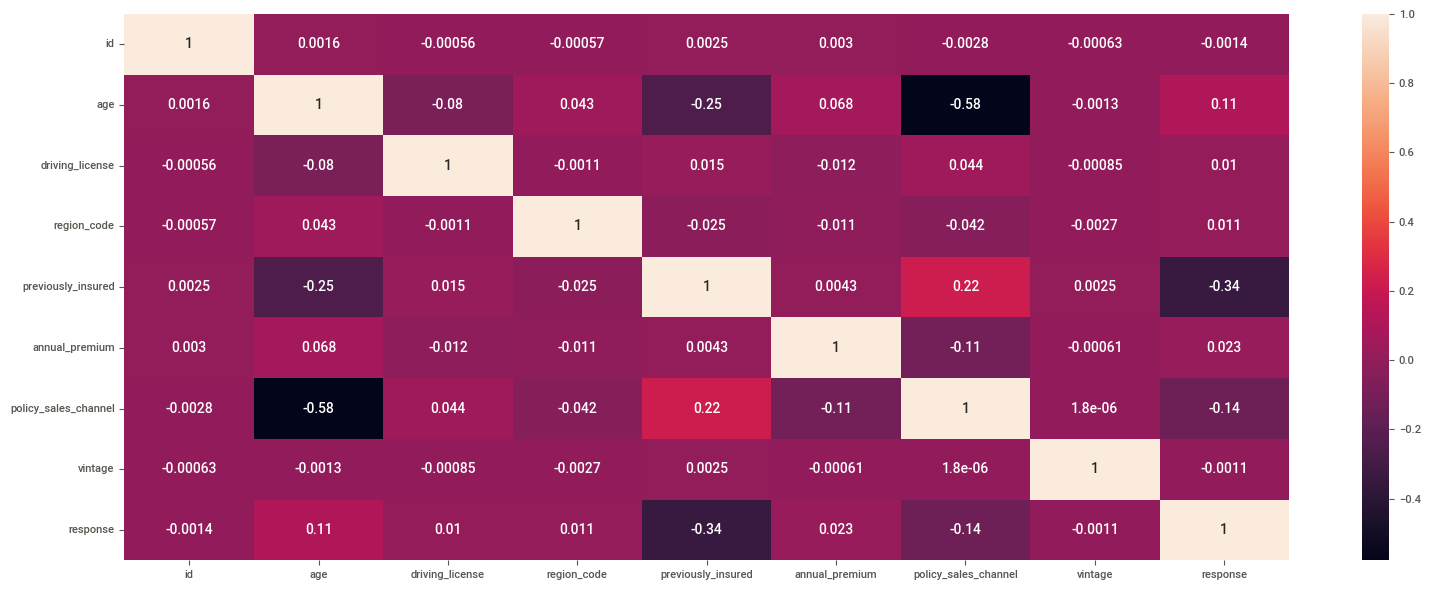

In [37]:
plt.figure(figsize=(16,6))
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

plt.tight_layout()
plt.show()

### 7.3.2 Categorical

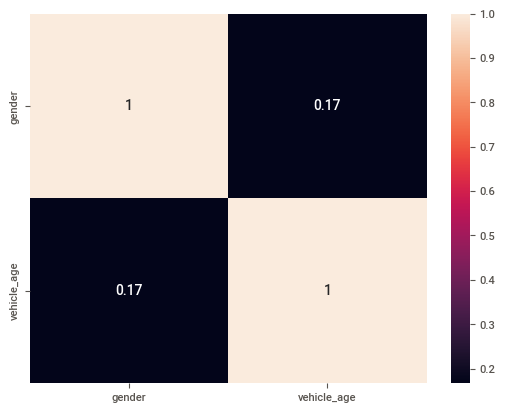

In [38]:
# Only categorical data
a = df4.select_dtypes(include='object')

# Calculate cramer v
a1 = cramer_v( a['gender'], a['gender'] )
a2 = cramer_v( a['gender'], a['vehicle_age'] )

a3 = cramer_v( a['vehicle_age'], a['gender'] )
a4 = cramer_v( a['vehicle_age'], a['vehicle_age'] )

# Final dataset
d = pd.DataFrame( {'gender': [a1, a2],
               'vehicle_age': [a3, a4],
               })

d = d.set_index(d.columns)

sns.heatmap(d, annot=True);

## 7.4 Insigths from EDA

In [39]:
description_insights()

╒════╤══════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Variable             │ Insights                                                                                                                                                         │
╞════╪══════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ Gender               │ - There are more men (54%) than women (46%) in the customer base                                                                                                 │
│    │                      │ - Of all customers, 12% are likely to buy insurance                                                                                                              │
│    │                      │ - 14%

# 8. Data Preparation

In [40]:
df5 = df4.copy()

In [41]:
X = df4.drop('response', axis=1)
y = df4['response'].copy()

x_train, x_val, y_train, y_val = ms.train_test_split(X, y, test_size=0.20)
df5 = pd.concat([x_train, y_train], axis=1)

In [42]:
# Standarization
df5 = standardization_data(df5)

# Rescaling
df5 = rescaling_data(df5)

# Encoder
df5 = encoding_data(df5)

In [44]:
# df5_val = pd.concat( [x_val, y_val], axis=1 )

x_val = standardization_data (x_val)
x_val = rescaling_data (x_val)

target_encode_gender = df5.groupby('gender')['response'].mean()
x_val.loc[:,'gender'] = x_val['gender'].map(target_encode_gender)

target_encode_region_code = df5.groupby('region_code')['response'].mean()
x_val.loc[:,'region_code'] = x_val['region_code'].map(target_encode_region_code)

x_val = pd.get_dummies(x_val, prefix='vehicle_age', columns=['vehicle_age'])

fe_policy_sales_channel = df5.groupby('policy_sales_channel').size() / len(df5)
x_val.loc[:,'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

x_val = x_val.fillna(0)

In [45]:
x_val.isna().sum()

id                              0
gender                          0
age                             0
driving_license                 0
region_code                     0
previously_insured              0
vehicle_damage                  0
annual_premium                  0
policy_sales_channel            0
vintage                         0
vehicle_age_below_1_year        0
vehicle_age_between_1_2_year    0
vehicle_age_over_2_years        0
dtype: int64

# 9. Feature Selection

In [46]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=100, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df5.drop(['id', 'response'], axis=1)
y_train_n = y_train.values
forest.fit(x_train_n, y_train_n)

ExtraTreesClassifier(n_jobs=-1, random_state=0)

Feature Ranking
                        feature  importance
0                       vintage    0.274054
0                annual_premium    0.245323
0                           age    0.163111
0                   region_code    0.105628
0                vehicle_damage    0.065041
0            previously_insured    0.059201
0          policy_sales_channel    0.058395
0      vehicle_age_below_1_year    0.014516
0  vehicle_age_between_1_2_year    0.006964
0                        gender    0.004697
0      vehicle_age_over_2_years    0.002613
0               driving_license    0.000456


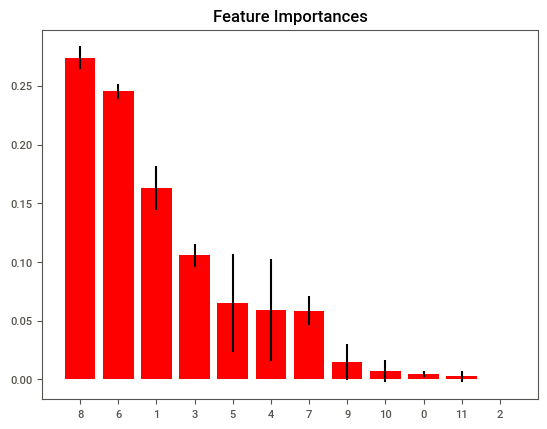

In [47]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature Ranking')
df = pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importance': j}, index=[0])
    df = pd.concat([df, aux], axis=0)

print(df.sort_values('importance', ascending=False))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title('Feature Importances')
plt.bar(range(x_train_n.shape[1]), importances[indices], color='r', yerr=std[indices], align='center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

# 10. Machine Learning

- We are not trying to find the best model to know whether the person will buy it or not.
- The intention is to create a list, ranking people most likely to purchase.
- We are interested in a good model capable of ordering a list. That's why we use ordering metrics (accumulated curve)

In [50]:
df6 = df5.copy()

cols_selected = ['vintage', 'annual_premium', 'age', 'region_code',
                 'vehicle_damage', 'policy_sales_channel',
                 'previously_insured']

x_train = df5[cols_selected]
x_valid = x_val[cols_selected]
y_val = y_val.copy()

## 10.1 KNN

In [51]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction - Generalization, not Learning
yhat_knn = knn_model.predict_proba(x_valid)

## 10.2 Logistic Regression

In [52]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict_proba(x_valid)

## 10.3 Extra Tree

In [53]:
# model definition
et = en.ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=42)

# model training
et.fit(x_train, y_train)

# model prediction
yhat_et = et.predict_proba(x_valid)

## 10.4 XGBoost

In [54]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, n_jobs=-1, random_state=42)

# model training
xgb_model.fit(x_train, y_train)

# model prediction
yhat_xgb = xgb_model.predict_proba(x_valid)

## 10.4 Models Comparation

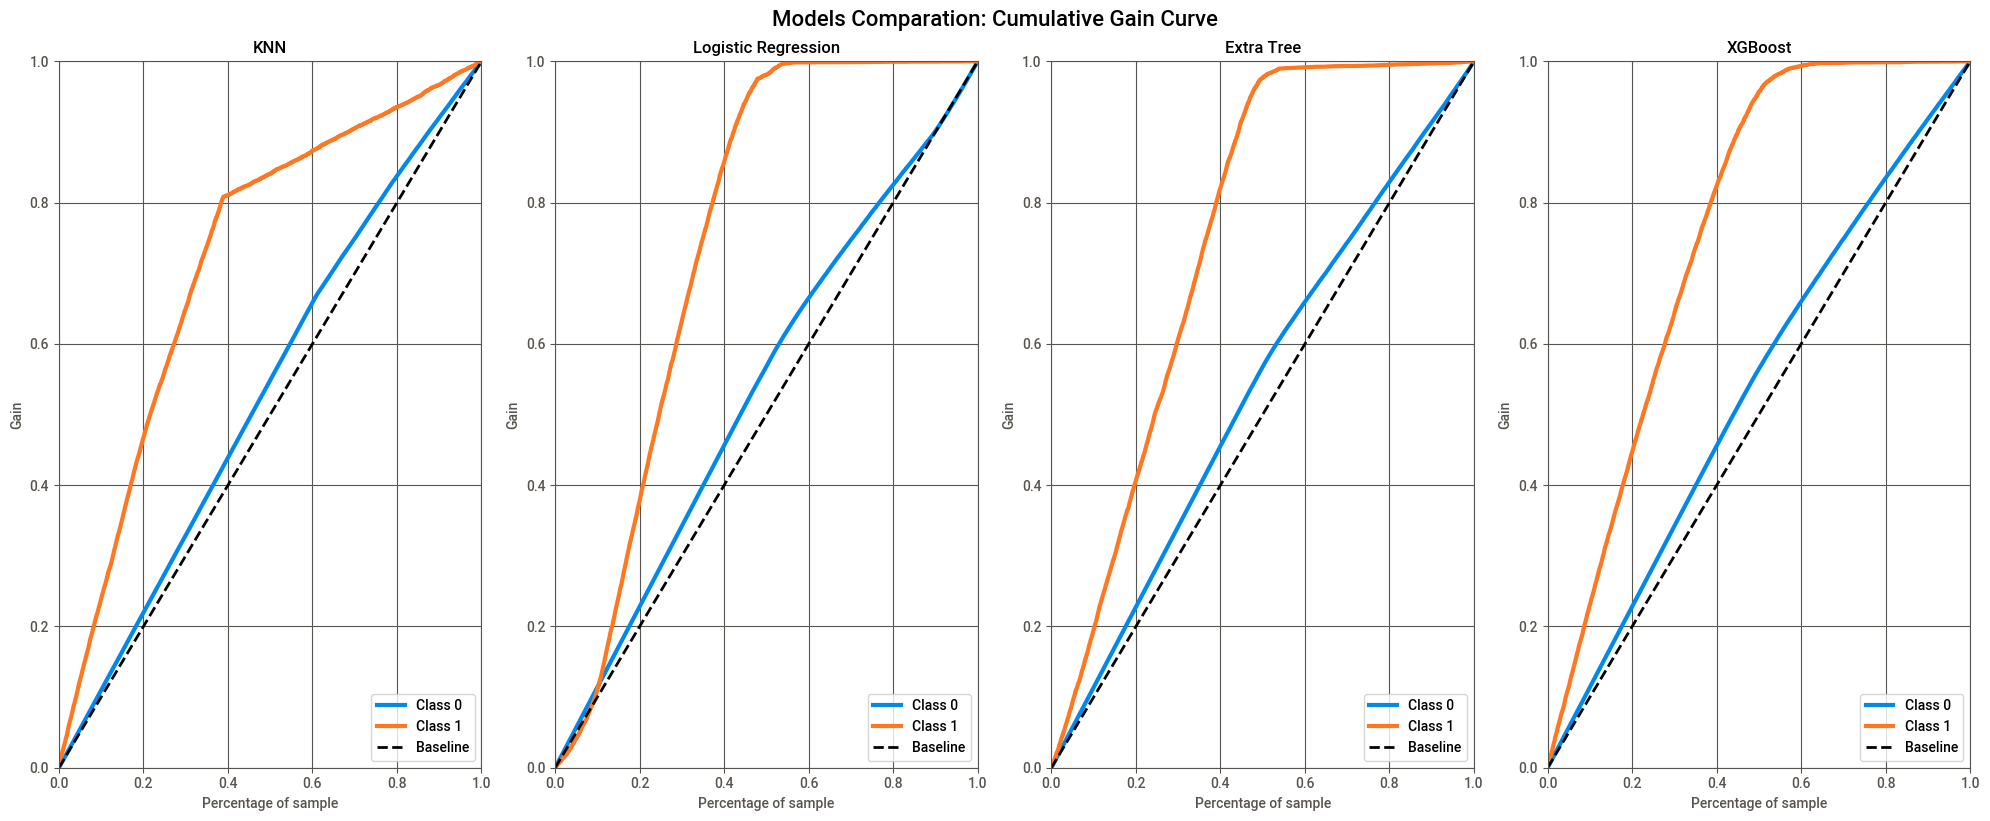

In [55]:
fig, axes = plt.subplots(1, 4, figsize=(20, 8))

# KNN
skplt.metrics.plot_cumulative_gain(y_val, yhat_knn, ax=axes[0])
axes[0].set_title('KNN')

# Logistic Regression
skplt.metrics.plot_cumulative_gain(y_val, yhat_lr, ax=axes[1])
axes[1].set_title('Logistic Regression')

# Extra Tree
skplt.metrics.plot_cumulative_gain(y_val, yhat_et, ax=axes[2])
axes[2].set_title('Extra Tree')

# XGBoost
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, ax=axes[3])
axes[3].set_title('XGBoost')

plt.tight_layout()
fig.suptitle('Models Comparation: Cumulative Gain Curve', fontsize=16, y=1.02)
plt.show()


## 10.5 Models Performance

In [56]:
knn_metrics = metrics_models(df6, 'KNN Classifier', y_val, yhat_knn, x_valid)
lr_metrics = metrics_models(df6, 'Logistic Regression', y_val, yhat_lr, x_valid)
et_metrics = metrics_models(df6, 'Extra Tree', y_val, yhat_et, x_valid)
xgb_metrics = metrics_models(df6, 'XGBoost', y_val, yhat_xgb, x_valid)
all_metrics = pd.concat([knn_metrics, lr_metrics, et_metrics, xgb_metrics], axis=0)
all_metrics.sort_values(by='Precision at K', ascending=False)

,Model Name,Precision at K,Recall at K
0,KNN Classifier,0.312844,0.066145
0,XGBoost,0.291854,0.061708
0,Extra Tree,0.215892,0.045647
0,Logistic Regression,0.088456,0.018702


In [57]:
knn_metrics_cv = cross_validation(knn_model, x_train, y_train, 5, df6, Verbose=False)
lr_metrics_cv = cross_validation(lr_model, x_train, y_train, 5, df6, Verbose=False)
et_metrics_cv = cross_validation(et, x_train, y_train, 5, df6, Verbose=False)
xgb_metrics_cv = cross_validation(xgb_model, x_train, y_train, 5, df6, Verbose=False)
all_metrics_cv = pd.concat([knn_metrics_cv, lr_metrics_cv, et_metrics_cv, xgb_metrics_cv], axis=0)
all_metrics_cv.sort_values(by='Precision Mean', ascending=False)

,Model Name,Balanced Accuracy Mean,Precision Mean,Precision STD,Precision@k Mean,Precision@k STD,Recall@k Mean,Recall@k STD
0,XGBClassifier,0.5414,0.3521,0.0108,0.3481,0.0073,0.1870,0.0039
0,ExtraTreesClassifier,0.5522,0.3375,0.0061,0.3387,0.0071,0.1819,0.0038
0,KNeighborsClassifier,0.5490,0.3344,0.0037,0.3279,0.0040,0.1761,0.0021
0,LogisticRegression,0.5000,0.0000,0.0000,0.2772,0.0035,0.1489,0.0019


# 11. Business Performance

## Strategy 1

- 26% of the customer base, ordered by purchase probability, contains 57% of all those interested in purchasing vehicle insurance.
- This corresponds to 20 thousand calls from the sales team.
- The proposed model is 2.3x better than a random choice.
- If we adopt 1000 dollars for each insurance, this model will achieve about US$ 22 million more in revenue than a random choice.

In [60]:
data = x_val.copy()
data['response'] = y_val.copy()
data['score'] = yhat_xgb[:, 1].tolist()
data = data.sort_values('score', ascending=False)

In [61]:
percent_of_dataset = 20000 / len(data)
recall_at_20000 = recall_at_k(data, k=20000)

print(percent_of_dataset)
print(recall_at_20000)

0.2623914355435439
0.5721682163989856


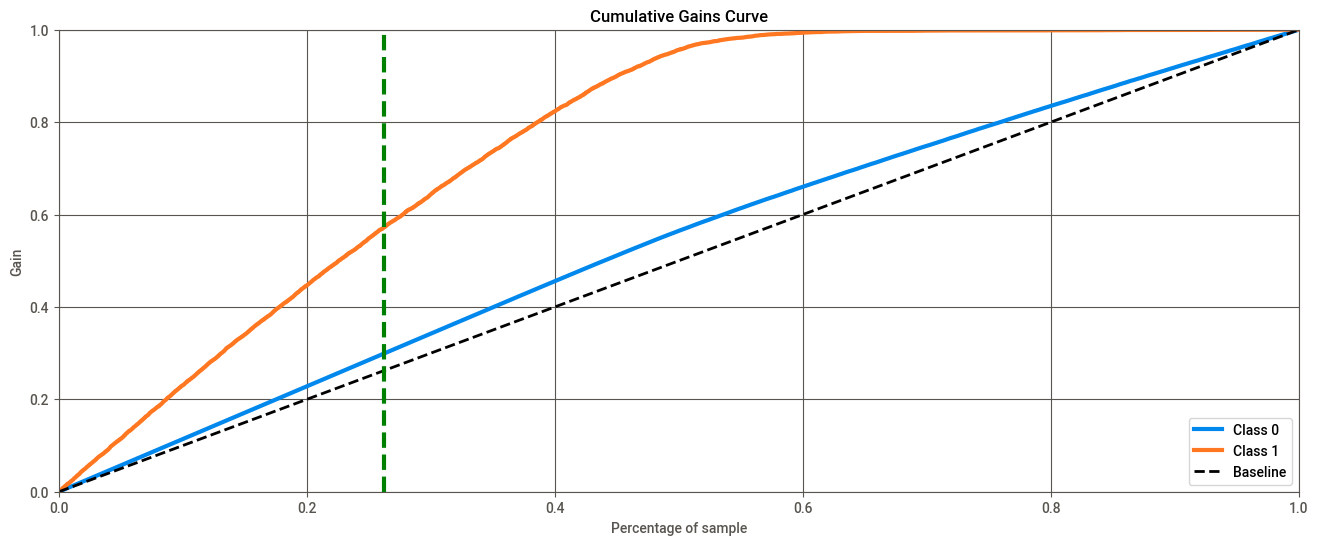

In [62]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, figsize=(16,6))
plt.axvline(0.2623, 0, 1, color='green', ls='--', lw=3)

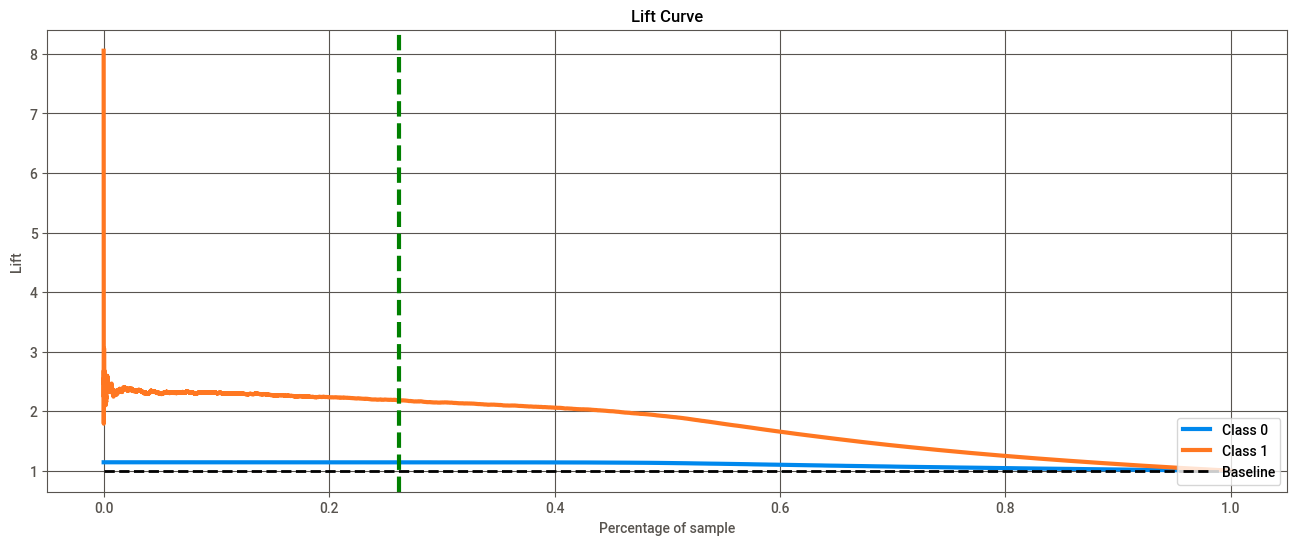

In [63]:
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, figsize=(16,6))
plt.axvline(0.2623, 0, 1, color='green', ls='--', lw=3)

In [64]:
random_choice = (28/100) * len(data)
model = (57/100) * len(data)

revenue_rc = random_choice * 1000
revenue_m = model * 1000

print(f'Revenue with Random Choice: US$ {revenue_rc:,.2f}')
print(f'Revenue with Model: US$ {revenue_m:,.2f}')
print()
print(f'Difference: US$ {(revenue_m - revenue_rc):,.2f}')

Revenue with Random Choice: US$ 21,342,160.00
Revenue with Model: US$ 43,446,540.00

Difference: US$ 22,104,380.00


## Strategy 2

- 35% of the customer base, ordered by purchase probability, contains 74% of all those interested in purchasing vehicle insurance.
- This corresponds to 27 thousand calls from the sales team.
- The proposed model is 2.1x better than a random choice.
- If we adopt 1000 dollars for each insurance, this model will achieve about US$ 26 million more in revenue than a random choice.

In [65]:
percent_of_dataset = 27000 / len(data)
recall_at_27000 = recall_at_k(data, k=27000)

print(percent_of_dataset)
print(recall_at_27000)

0.35422843798378423
0.7433431952662722


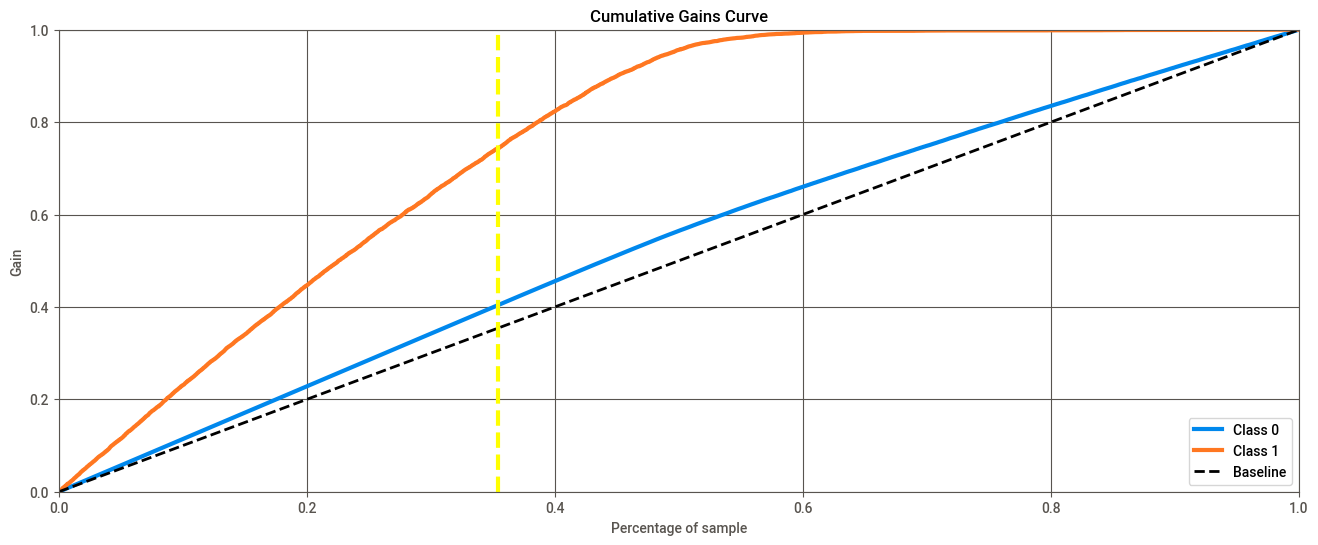

In [66]:
skplt.metrics.plot_cumulative_gain(y_val, yhat_xgb, figsize=(16,6))
plt.axvline(0.3542, 0, 1, color='yellow', ls='--', lw=3)

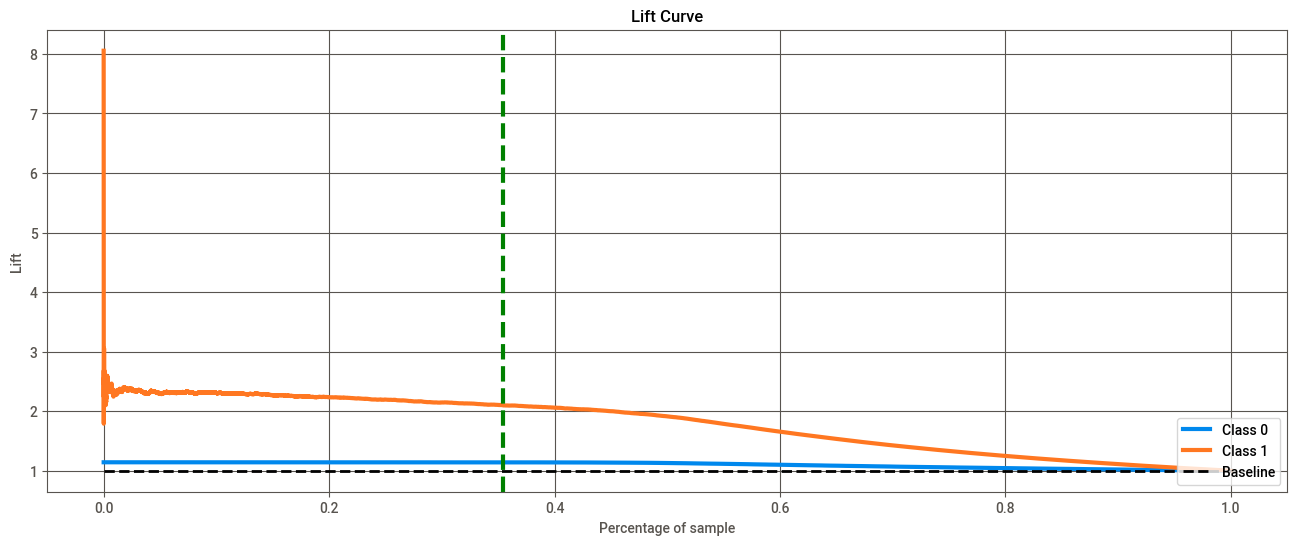

In [67]:
skplt.metrics.plot_lift_curve(y_val, yhat_xgb, figsize=(16,6))
plt.axvline(0.3542, 0, 1, color='green', ls='--', lw=3)

In [68]:
random_choice = (40/100) * len(data)
model = (74/100) * len(data)

revenue_rc = random_choice * 1000
revenue_m = model * 1000

print(f'Revenue with Random Choice: US$ {revenue_rc:,.2f}')
print(f'Revenue with Model: US$ {revenue_m:,.2f}')
print()
print(f'Difference: US$ {(revenue_m - revenue_rc):,.2f}')

Revenue with Random Choice: US$ 30,488,800.00
Revenue with Model: US$ 56,404,280.00

Difference: US$ 25,915,480.00


# 12. Deploy to Production

In [69]:
# Save trained model
pickle.dump(lr_model, open("C:/Users/Felipe/Documents/Felipe/CienciaDeDados/repos/purchasing_propensity/api/models/model_health_insurance_cross_sell.pkl", 'wb'))

## 12.1 API Tester

In [70]:
df_test = x_val
df_test['response'] = y_val

In [71]:
df_test = df_test.sample(10)

In [72]:
df_test.head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_damage,annual_premium,policy_sales_channel,vintage,vehicle_age_below_1_year,vehicle_age_between_1_2_year,vehicle_age_over_2_years,response
29473,29474,0,0.061538,1,0.0,1,0,1.645257,0.0,0.276817,True,False,False,0
123099,123100,0,0.030769,1,0.0,1,0,-0.164544,0.0,0.505190,True,False,False,0
346017,346018,0,0.030769,1,0.0,0,1,-0.898702,0.0,0.525952,True,False,False,0
84164,84165,0,0.076923,1,0.0,1,0,0.219503,0.0,0.283737,True,False,False,0
35108,35109,0,0.046154,1,0.0,1,0,0.012784,0.0,0.442907,True,False,False,0


In [73]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [74]:
# # API Call
# # url = 'http://localhost:5000/predict'
# url = 'https://insurancecrosssell.onrender.com/'
# header = {'Content-type': 'application/json' }

# r = requests.post(url, json=data, headers=header)
# print('Status Code {}'.format( r.status_code ))
# # print('Response {}'.format( r.json() ))

In [75]:
# d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
# d1.sort_values('score', ascending=False).head()